# Install dependencies and libs

In [1]:
# @title Update/Upgrade the system and install libs
!apt-get update > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install -y swig build-essential python-dev python3-dev > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1
!apt-get install xvfb > /dev/null 2>&1

In [2]:
# @title Install dependencies
!pip install rarfile --quiet
!pip install stable-baselines3[extra] --quiet
!pip install ale-py --quiet
!pip install gym[box2d] --quiet
!pip install pyvirtualdisplay --quiet
!pip install pyglet --quiet
!pip install pygame --quiet
!pip install minigrid --quiet
!pip install -q swig --quiet
!pip install -q gymnasium[box2d] --quiet
!pip install 'minigrid<=2.1.1' --quiet
!pip3 install box2d-py --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 11.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 57.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed build

In [3]:
# @title Imports
import io
import os
import glob
import torch
import base64

import numpy as np
import matplotlib.pyplot as plt

import sys
import gymnasium
sys.modules["gym"] = gymnasium

import stable_baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env

import gymnasium as gym
from gym import spaces
from gym.envs.box2d.lunar_lander import *
from gym.wrappers.monitoring.video_recorder import VideoRecorder

In [4]:
# @title Play Video function
from IPython.display import HTML
from base64 import b64encode
from pyvirtualdisplay import Display

# create the directory to store the video(s)
os.makedirs("./video", exist_ok=True)

display = Display(visible=False, size=(1400, 900))
_ = display.start()

"""
Utility functions to enable video recording of gym environment
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Create directory

In [5]:
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Enviroment

Used enviroment is Lunar Lander from gym.

**Action Space**
There are four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

**Observation Space**

The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

**Rewards**

Reward for moving from the top of the screen to the landing pad and coming to rest is about 100-140 points. If the lander moves away from the landing pad, it loses reward. If the lander crashes, it receives an additional -100 points. If it comes to rest, it receives an additional +100 points. Each leg with ground contact is +10 points. Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame. Solved is 200 points.

In [6]:
env_name = 'LunarLander-v2'
env = gym.make(env_name)

In [7]:
env = gym.make(env_name, render_mode="rgb_array")
vid = VideoRecorder(env, path=f"video/{env_name}_first_run.mp4")
observation = env.reset()[0]

total_reward = 0
done = False
while not done:
  frame = env.render()
  vid.capture_frame()
  action = np.random.randint(4)
  observation, reward, done, info, _ = env.step(action)
  total_reward += reward
vid.close()
env.close()
print(f"\nTotal reward: {total_reward}")

# show video
html = render_mp4(f"video/{env_name}_first_run.mp4")
HTML(html)

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(



Total reward: -318.52618592550374


# Q Learaning

**Action Space**

There are four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

**Observation Space**

The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

**Rewards**

Reward for moving from the top of the screen to the landing pad and coming to rest is about 100-140 points. If the lander moves away from the landing pad, it loses reward. If the lander crashes, it receives an additional -100 points. If it comes to rest, it receives an additional +100 points. Each leg with ground contact is +10 points. Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame. Solved is 200 points.

Discretization of the continuous states

In [ ]:
DISCRETE_OS_SIZE = [20, 20 ,20 ,20,20,20 ,1,1]
discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/DISCRETE_OS_SIZE

In [ ]:


env = gym.make(env_name, render_mode="rgb_array")

LEARNING_RATE = 0.1

DISCOUNT = 0.95
EPISODES = 50000
SHOW_EVERY = 5000

DISCRETE_OS_SIZE = [20, 20 ,20 ,20,20,20 ,1,1]

discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/DISCRETE_OS_SIZE

# Exploration settings
epsilon = 1# not a constant, qoing to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES//2
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)


q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE + [env.action_space.n]))


reward_list=[]

def get_discrete_state(state):
    discrete_state = (state[0] - env.observation_space.low)/discrete_os_win_size
    return tuple(discrete_state.astype(int))  # we use this tuple to look up the 3 Q values for the available actions in the q-table


for episode in range(EPISODES+1):
    discrete_state = get_discrete_state(env.reset())
    done = False
    tik=0
    if episode % SHOW_EVERY == 0:
        render = True
        vid = VideoRecorder(env, path=f"video/{env_name}_Q_learning_{episode}.mp4")
    else:
        render = False

    while not done:
        tik+=1
        if tik>5000:
          break
        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(q_table[discrete_state])
        else:
            # Get random action
            action = np.random.randint(0, env.action_space.n)


        new_state, reward, done, info, _= env.step(action)
        new_discrete_state = get_discrete_state(new_state)
        reward_list.append(reward)
        if episode % SHOW_EVERY == 0:
            frame = env.render()
            vid.capture_frame()
        #new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)

        # If simulation did not end yet after last step - update Q table
        if not done:

            # Maximum possible Q value in next step (for new state)
            max_future_q = np.max(q_table[new_discrete_state])

            # Current Q value (for current state and performed action)
            current_q = q_table[discrete_state + (action,)]

            # And here's our equation for a new Q value for current state and action
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)

            # Update Q table with new Q value
            q_table[discrete_state + (action,)] = new_q


        # Simulation ended (for any reson) - if goal position is achived - update Q value with reward directly
        else:
            q_table[discrete_state + (action,)] = reward

        discrete_state = new_discrete_state
    if episode % SHOW_EVERY == 0:
        vid.close()
        env.close()
        print(f"\nTotal reward: {total_reward}")

        # show video


    # Decaying is being done every episode if episode number is within decaying range
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value


env.close()

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(



Total reward: -141.05067618274546


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(



Total reward: -141.05067618274546


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(



Total reward: -141.05067618274546


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(



Total reward: -141.05067618274546


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(



Total reward: -141.05067618274546


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(



Total reward: -141.05067618274546


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(



Total reward: -141.05067618274546


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(



Total reward: -141.05067618274546


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(



Total reward: -141.05067618274546


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(



Total reward: -141.05067618274546


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(



Total reward: -141.05067618274546


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, "Performance of Q-Learning on 'LunarLander-v2'")

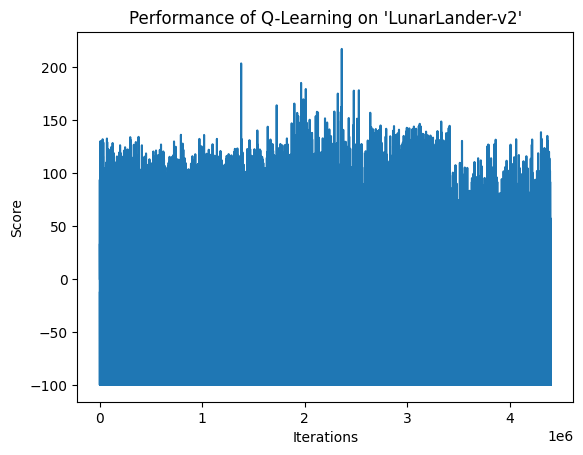

In [ ]:

import matplotlib.pyplot as plt

plt.plot(range(len(reward_list)),reward_list)
plt.xlabel("Iterations")
plt.ylabel("Score")
plt.title("Performance of Q-Learning on 'LunarLander-v2'")

In [ ]:
html = render_mp4(f"video/{env_name}_Q_learning_{50000}.mp4")
HTML(html)

# DQN

In [6]:
!pip install gym numpy torch

In [7]:
nn_layers = [64, 64,64]
learning_rate = 0.0001
exploration_initial_eps = 1  # initial value of random action probability. Range is between 0 and 1.
exploration_fraction = 0.5  # fraction of entire training period over which the exploration rate is reduced. Range is between 0 and 1.



In [8]:

log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env_name = 'LunarLander-v2'
env = gym.make(env_name)

env = stable_baselines3.common.monitor.Monitor(env, log_dir )

callback = EvalCallback(env, log_path=log_dir, deterministic=True)  # For evaluating the performance of the agent periodically and logging the results.
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=nn_layers)

model = DQN("MlpPolicy", env,policy_kwargs = policy_kwargs,
            learning_rate=learning_rate,
            batch_size=128,  # for simplicity, we are not doing batch update.
            buffer_size=128,  # size of experience of replay buffer. Set to 1 as batch update is not done
            learning_starts=1,  # learning starts immediately!
            gamma=0.99,  # discount facto. range is between 0 and 1.
            tau = 1,  # the soft update coefficient for updating the target network
            target_update_interval=50,  # update the target network immediately.
            train_freq=(1,"step"),  # train the network at every step.
            max_grad_norm = 10,  # the maximum value for the gradient clipping
            exploration_initial_eps = 1,  # initial value of random action probability
            exploration_fraction = 0.5,  # fraction of entire training period over which the exploration rate is reduced
            gradient_steps = 1,  # number of gradient steps
            seed = 1,  # seed for the pseudo random generators
            verbose=0)  # Set verbose to 1 to observe training logs. We encourage you to set the verbose to 1.


In [29]:
env = gym.make(env_name, render_mode="rgb_array")
vid = VideoRecorder(env, path=f"video/{env_name}_pretraining.mp4")
observation = env.reset()[0]

total_reward = 0
done = False
while not done:
  frame = env.render()
  vid.capture_frame()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info, _ = env.step(action)
  total_reward += reward
vid.close()
env.close()
print(f"\nTotal reward: {total_reward}")

# show video
html = render_mp4(f"video/{env_name}_pretraining.mp4")
HTML(html)

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(



Total reward: -613.0409371933624


In [40]:
model.learn(total_timesteps=100000, log_interval=10, callback=callback)

# Save the model
model_path = os.path.join(log_dir, "default_model.zip")
model.save(model_path)

print(f"Model saved to {model_path}")

from google.colab import files

# Download the file to your local machine
files.download(model_path)

Eval num_timesteps=10000, episode_reward=-22.31 +/- 34.01
Episode length: 158.00 +/- 25.35
New best mean reward!
Eval num_timesteps=20000, episode_reward=-211.44 +/- 54.49
Episode length: 438.40 +/- 139.00
Eval num_timesteps=30000, episode_reward=-162.76 +/- 18.66
Episode length: 214.40 +/- 51.23
Eval num_timesteps=40000, episode_reward=-33.99 +/- 40.85
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=-45.48 +/- 100.79
Episode length: 401.00 +/- 192.91
Eval num_timesteps=60000, episode_reward=-42.75 +/- 21.56
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=-13.63 +/- 22.38
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=80000, episode_reward=-138.15 +/- 21.93
Episode length: 171.20 +/- 37.97
Eval num_timesteps=90000, episode_reward=-69.17 +/- 60.11
Episode length: 542.60 +/- 379.29
Eval num_timesteps=100000, episode_reward=9.95 +/- 168.35
Episode length: 510.80 +/- 193.55
New best mean reward!
Model saved to /

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
# Load the model
model_path = os.path.join(log_dir, "default_model.zip")

model = DQN.load(model_path, env=env)

print("Model loaded successfully!")

Model loaded successfully!


In [25]:
env = gym.make(env_name, render_mode="rgb_array")
vid = VideoRecorder(env, path=f"video/{env_name}_learned.mp4")
observation = env.reset()[0]

total_reward = 0
done = False
while not done:
  frame = env.render()
  vid.capture_frame()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info, _ = env.step(action)
  total_reward += reward
vid.close()
env.close()
print(f"\nTotal reward: {total_reward}")

# show video
html = render_mp4(f"video/{env_name}_learned.mp4")
HTML(html)

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(



Total reward: 256.8226369909967


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


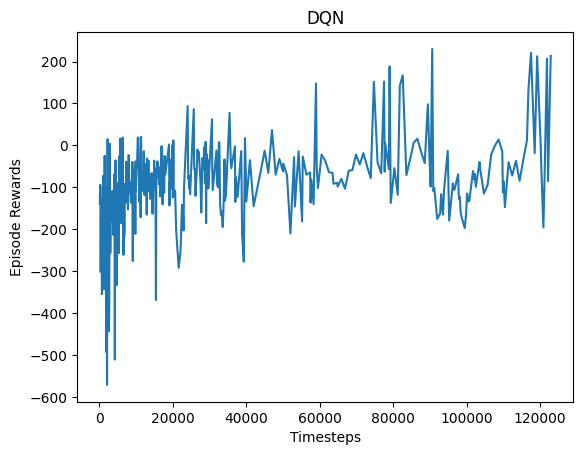

In [64]:
x, y = ts2xy(load_results(log_dir), 'timesteps')
plt.plot(x, y)
# plt.ylim([-300, 300])
plt.title('DQN')
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')
plt.show()

In [6]:

import math
import warnings
from typing import TYPE_CHECKING, Optional

import numpy as np

import gym
from gym import error, spaces
from gym.error import DependencyNotInstalled
from gym.utils import EzPickle, colorize
from gym.utils.step_api_compatibility import step_api_compatibility

try:
    import Box2D
    from Box2D.b2 import (
        circleShape,
        contactListener,
        edgeShape,
        fixtureDef,
        polygonShape,
        revoluteJointDef,
    )
except ImportError:
    raise DependencyNotInstalled("box2d is not installed, run `pip install gym[box2d]`")


if TYPE_CHECKING:
    import pygame


FPS = 50
SCALE = 30.0  # affects how fast-paced the game is, forces should be adjusted as well

MAIN_ENGINE_POWER = 13.0
SIDE_ENGINE_POWER = 0.6

INITIAL_RANDOM = 1000.0  # Set 1500 to make game harder

LANDER_POLY = [(-14, +17), (-17, 0), (-17, -10), (+17, -10), (+17, 0), (+14, +17)]
LEG_AWAY = 20
LEG_DOWN = 18
LEG_W, LEG_H = 2, 8
LEG_SPRING_TORQUE = 40

SIDE_ENGINE_HEIGHT = 14.0
SIDE_ENGINE_AWAY = 12.0

VIEWPORT_W = 600
VIEWPORT_H = 400


class ContactDetector(contactListener):
    def __init__(self, env):
        contactListener.__init__(self)
        self.env = env

    def BeginContact(self, contact):
        if (
            self.env.lander == contact.fixtureA.body
            or self.env.lander == contact.fixtureB.body
        ):
            self.env.game_over = True
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = True

    def EndContact(self, contact):
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = False


class CustomLunarLander(gym.Env, EzPickle):
    """
    ### Description
    This environment is a classic rocket trajectory optimization problem.
    According to Pontryagin's maximum principle, it is optimal to fire the
    engine at full throttle or turn it off. This is the reason why this
    environment has discrete actions: engine on or off.

    There are two environment versions: discrete or continuous.
    The landing pad is always at coordinates (0,0). The coordinates are the
    first two numbers in the state vector.
    Landing outside of the landing pad is possible. Fuel is infinite, so an agent
    can learn to fly and then land on its first attempt.

    To see a heuristic landing, run:
    ```
    python gym/envs/box2d/lunar_lander.py
    ```
    <!-- To play yourself, run: -->
    <!-- python examples/agents/keyboard_agent.py LunarLander-v2 -->

    ### Action Space
    There are four discrete actions available: do nothing, fire left
    orientation engine, fire main engine, fire right orientation engine.

    ### Observation Space
    The state is an 8-dimensional vector: the coordinates of the lander in `x` & `y`, its linear
    velocities in `x` & `y`, its angle, its angular velocity, and two booleans
    that represent whether each leg is in contact with the ground or not.

    ### Rewards
    After every step a reward is granted. The total reward of an episode is the
    sum of the rewards for all the steps within that episode.

    For each step, the reward:
    - is increased/decreased the closer/further the lander is to the landing pad.
    - is increased/decreased the slower/faster the lander is moving.
    - is decreased the more the lander is tilted (angle not horizontal).
    - is increased by 10 points for each leg that is in contact with the ground.
    - is decreased by 0.03 points each frame a side engine is firing.
    - is decreased by 0.3 points each frame the main engine is firing.

    The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

    An episode is considered a solution if it scores at least 200 points.

    ### Starting State
    The lander starts at the top center of the viewport with a random initial
    force applied to its center of mass.

    ### Episode Termination
    The episode finishes if:
    1) the lander crashes (the lander body gets in contact with the moon);
    2) the lander gets outside of the viewport (`x` coordinate is greater than 1);
    3) the lander is not awake. From the [Box2D docs](https://box2d.org/documentation/md__d_1__git_hub_box2d_docs_dynamics.html#autotoc_md61),
        a body which is not awake is a body which doesn't move and doesn't
        collide with any other body:
    > When Box2D determines that a body (or group of bodies) has come to rest,
    > the body enters a sleep state which has very little CPU overhead. If a
    > body is awake and collides with a sleeping body, then the sleeping body
    > wakes up. Bodies will also wake up if a joint or contact attached to
    > them is destroyed.

    ### Arguments
    To use to the _continuous_ environment, you need to specify the
    `continuous=True` argument like below:
    ```python
    import gym
    env = gym.make(
        "LunarLander-v2",
        continuous: bool = False,
        gravity: float = -10.0,
        enable_wind: bool = False,
        wind_power: float = 15.0,
        turbulence_power: float = 1.5,
    )
    ```
    If `continuous=True` is passed, continuous actions (corresponding to the throttle of the engines) will be used and the
    action space will be `Box(-1, +1, (2,), dtype=np.float32)`.
    The first coordinate of an action determines the throttle of the main engine, while the second
    coordinate specifies the throttle of the lateral boosters.
    Given an action `np.array([main, lateral])`, the main engine will be turned off completely if
    `main < 0` and the throttle scales affinely from 50% to 100% for `0 <= main <= 1` (in particular, the
    main engine doesn't work  with less than 50% power).
    Similarly, if `-0.5 < lateral < 0.5`, the lateral boosters will not fire at all. If `lateral < -0.5`, the left
    booster will fire, and if `lateral > 0.5`, the right booster will fire. Again, the throttle scales affinely
    from 50% to 100% between -1 and -0.5 (and 0.5 and 1, respectively).

    `gravity` dictates the gravitational constant, this is bounded to be within 0 and -12.

    If `enable_wind=True` is passed, there will be wind effects applied to the lander.
    The wind is generated using the function `tanh(sin(2 k (t+C)) + sin(pi k (t+C)))`.
    `k` is set to 0.01.
    `C` is sampled randomly between -9999 and 9999.

    `wind_power` dictates the maximum magnitude of linear wind applied to the craft. The recommended value for `wind_power` is between 0.0 and 20.0.
    `turbulence_power` dictates the maximum magnitude of rotational wind applied to the craft. The recommended value for `turbulence_power` is between 0.0 and 2.0.

    ### Version History
    - v2: Count energy spent and in v0.24, added turbulance with wind power and turbulence_power parameters
    - v1: Legs contact with ground added in state vector; contact with ground
        give +10 reward points, and -10 if then lose contact; reward
        renormalized to 200; harder initial random push.
    - v0: Initial version

    <!-- ### References -->

    ### Credits
    Created by Oleg Klimov
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": FPS,
    }

    def __init__(
        self,
        render_mode: Optional[str] = None,
        continuous: bool = False,
        gravity: float = -10.0,
        enable_wind: bool = False,
        wind_power: float = 15.0,
        turbulence_power: float = 1.5,
    ):
        EzPickle.__init__(
            self,
            render_mode,
            continuous,
            gravity,
            enable_wind,
            wind_power,
            turbulence_power,
        )

        assert (
            -12.0 < gravity and gravity < 0.0
        ), f"gravity (current value: {gravity}) must be between -12 and 0"
        self.gravity = gravity

        if 0.0 > wind_power or wind_power > 20.0:
            warnings.warn(
                colorize(
                    f"WARN: wind_power value is recommended to be between 0.0 and 20.0, (current value: {wind_power})",
                    "yellow",
                ),
            )
        self.wind_power = wind_power

        if 0.0 > turbulence_power or turbulence_power > 2.0:
            warnings.warn(
                colorize(
                    f"WARN: turbulence_power value is recommended to be between 0.0 and 2.0, (current value: {turbulence_power})",
                    "yellow",
                ),
            )
        self.turbulence_power = turbulence_power

        self.enable_wind = enable_wind
        self.wind_idx = np.random.randint(-9999, 9999)
        self.torque_idx = np.random.randint(-9999, 9999)

        self.screen: pygame.Surface = None
        self.clock = None
        self.isopen = True
        self.world = Box2D.b2World(gravity=(0, gravity))
        self.moon = None
        self.lander: Optional[Box2D.b2Body] = None
        self.particles = []

        self.prev_reward = None

        self.continuous = continuous

        low = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                -1.5,
                -1.5,
                # velocity bounds is 5x rated speed
                -5.0,
                -5.0,
                -math.pi,
                -5.0,
                -0.0,
                -0.0,
            ]
        ).astype(np.float32)
        high = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                1.5,
                1.5,
                # velocity bounds is 5x rated speed
                5.0,
                5.0,
                math.pi,
                5.0,
                1.0,
                1.0,
            ]
        ).astype(np.float32)

        # useful range is -1 .. +1, but spikes can be higher
        self.observation_space = spaces.Box(low, high)

        if self.continuous:
            # Action is two floats [main engine, left-right engines].
            # Main engine: -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power.
            # Left-right:  -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off
            self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)
        else:
            # Nop, fire left engine, main engine, right engine
            self.action_space = spaces.Discrete(4)

        self.render_mode = render_mode

    def _destroy(self):
        if not self.moon:
            return
        self.world.contactListener = None
        self._clean_particles(True)
        self.world.DestroyBody(self.moon)
        self.moon = None
        self.world.DestroyBody(self.lander)
        self.lander = None
        self.world.DestroyBody(self.legs[0])
        self.world.DestroyBody(self.legs[1])

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self._destroy()
        self.world.contactListener_keepref = ContactDetector(self)
        self.world.contactListener = self.world.contactListener_keepref
        self.game_over = False
        self.prev_shaping = None

        W = VIEWPORT_W / SCALE
        H = VIEWPORT_H / SCALE

        # terrain
        CHUNKS = 11
        height = self.np_random.uniform(0, H / 2, size=(CHUNKS + 1,))
        chunk_x = [W / (CHUNKS - 1) * i for i in range(CHUNKS)]
        self.helipad_x1 = chunk_x[CHUNKS // 2 - 1]
        self.helipad_x2 = chunk_x[CHUNKS // 2 + 1]
        self.helipad_y = H / 4
        height[CHUNKS // 2 - 2] = self.helipad_y
        height[CHUNKS // 2 - 1] = self.helipad_y
        height[CHUNKS // 2 + 0] = self.helipad_y
        height[CHUNKS // 2 + 1] = self.helipad_y
        height[CHUNKS // 2 + 2] = self.helipad_y
        smooth_y = [
            0.33 * (height[i - 1] + height[i + 0] + height[i + 1])
            for i in range(CHUNKS)
        ]

        self.moon = self.world.CreateStaticBody(
            shapes=edgeShape(vertices=[(0, 0), (W, 0)])
        )
        self.sky_polys = []
        for i in range(CHUNKS - 1):
            p1 = (chunk_x[i], smooth_y[i])
            p2 = (chunk_x[i + 1], smooth_y[i + 1])
            self.moon.CreateEdgeFixture(vertices=[p1, p2], density=0, friction=0.1)
            self.sky_polys.append([p1, p2, (p2[0], H), (p1[0], H)])

        self.moon.color1 = (0.0, 0.0, 0.0)
        self.moon.color2 = (0.0, 0.0, 0.0)

        initial_y = VIEWPORT_H / SCALE
        self.lander: Box2D.b2Body = self.world.CreateDynamicBody(
            position=(VIEWPORT_W / SCALE / 2, initial_y),
            angle=0.0,
            fixtures=fixtureDef(
                shape=polygonShape(
                    vertices=[(x / SCALE, y / SCALE) for x, y in LANDER_POLY]
                ),
                density=5.0,
                friction=0.1,
                categoryBits=0x0010,
                maskBits=0x001,  # collide only with ground
                restitution=0.0,
            ),  # 0.99 bouncy
        )
        self.lander.color1 = (128, 102, 230)
        self.lander.color2 = (77, 77, 128)
        self.lander.ApplyForceToCenter(
            (
                self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
                self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
            ),
            True,
        )

        self.legs = []
        for i in [-1, +1]:
            leg = self.world.CreateDynamicBody(
                position=(VIEWPORT_W / SCALE / 2 - i * LEG_AWAY / SCALE, initial_y),
                angle=(i * 0.05),
                fixtures=fixtureDef(
                    shape=polygonShape(box=(LEG_W / SCALE, LEG_H / SCALE)),
                    density=1.0,
                    restitution=0.0,
                    categoryBits=0x0020,
                    maskBits=0x001,
                ),
            )
            leg.ground_contact = False
            leg.color1 = (128, 102, 230)
            leg.color2 = (77, 77, 128)
            rjd = revoluteJointDef(
                bodyA=self.lander,
                bodyB=leg,
                localAnchorA=(0, 0),
                localAnchorB=(i * LEG_AWAY / SCALE, LEG_DOWN / SCALE),
                enableMotor=True,
                enableLimit=True,
                maxMotorTorque=LEG_SPRING_TORQUE,
                motorSpeed=+0.3 * i,  # low enough not to jump back into the sky
            )
            if i == -1:
                rjd.lowerAngle = (
                    +0.9 - 0.5
                )  # The most esoteric numbers here, angled legs have freedom to travel within
                rjd.upperAngle = +0.9
            else:
                rjd.lowerAngle = -0.9
                rjd.upperAngle = -0.9 + 0.5
            leg.joint = self.world.CreateJoint(rjd)
            self.legs.append(leg)

        self.drawlist = [self.lander] + self.legs

        if self.render_mode == "human":
            self.render()
        return self.step(np.array([0, 0]) if self.continuous else 0)[0], {}

    def _create_particle(self, mass, x, y, ttl):
        p = self.world.CreateDynamicBody(
            position=(x, y),
            angle=0.0,
            fixtures=fixtureDef(
                shape=circleShape(radius=2 / SCALE, pos=(0, 0)),
                density=mass,
                friction=0.1,
                categoryBits=0x0100,
                maskBits=0x001,  # collide only with ground
                restitution=0.3,
            ),
        )
        p.ttl = ttl
        self.particles.append(p)
        self._clean_particles(False)
        return p

    def _clean_particles(self, all):
        while self.particles and (all or self.particles[0].ttl < 0):
            self.world.DestroyBody(self.particles.pop(0))

    def step(self, action):
        assert self.lander is not None

        # Update wind
        assert self.lander is not None, "You forgot to call reset()"
        if self.enable_wind and not (
            self.legs[0].ground_contact or self.legs[1].ground_contact
        ):
            # the function used for wind is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            wind_mag = (
                math.tanh(
                    math.sin(0.02 * self.wind_idx)
                    + (math.sin(math.pi * 0.01 * self.wind_idx))
                )
                * self.wind_power
            )
            self.wind_idx += 1
            self.lander.ApplyForceToCenter(
                (wind_mag, 0.0),
                True,
            )

            # the function used for torque is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            torque_mag = math.tanh(
                math.sin(0.02 * self.torque_idx)
                + (math.sin(math.pi * 0.01 * self.torque_idx))
            ) * (self.turbulence_power)
            self.torque_idx += 1
            self.lander.ApplyTorque(
                (torque_mag),
                True,
            )

        if self.continuous:
            action = np.clip(action, -1, +1).astype(np.float32)
        else:
            assert self.action_space.contains(
                action
            ), f"{action!r} ({type(action)}) invalid "

        # Engines
        tip = (math.sin(self.lander.angle), math.cos(self.lander.angle))
        side = (-tip[1], tip[0])
        dispersion = [self.np_random.uniform(-1.0, +1.0) / SCALE for _ in range(2)]

        m_power = 0.0
        if (self.continuous and action[0] > 0.0) or (
            not self.continuous and action == 2
        ):
            # Main engine
            if self.continuous:
                m_power = (np.clip(action[0], 0.0, 1.0) + 1.0) * 0.5  # 0.5..1.0
                assert m_power >= 0.5 and m_power <= 1.0
            else:
                m_power = 1.0
            # 4 is move a bit downwards, +-2 for randomness
            ox = tip[0] * (4 / SCALE + 2 * dispersion[0]) + side[0] * dispersion[1]
            oy = -tip[1] * (4 / SCALE + 2 * dispersion[0]) - side[1] * dispersion[1]
            impulse_pos = (self.lander.position[0] + ox, self.lander.position[1] + oy)
            p = self._create_particle(
                3.5,  # 3.5 is here to make particle speed adequate
                impulse_pos[0],
                impulse_pos[1],
                m_power,
            )  # particles are just a decoration
            p.ApplyLinearImpulse(
                (ox * MAIN_ENGINE_POWER * m_power, oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * MAIN_ENGINE_POWER * m_power, -oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )

        s_power = 0.0
        if (self.continuous and np.abs(action[1]) > 0.5) or (
            not self.continuous and action in [1, 3]
        ):
            # Orientation engines
            if self.continuous:
                direction = np.sign(action[1])
                s_power = np.clip(np.abs(action[1]), 0.5, 1.0)
                assert s_power >= 0.5 and s_power <= 1.0
            else:
                direction = action - 2
                s_power = 1.0
            ox = tip[0] * dispersion[0] + side[0] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            oy = -tip[1] * dispersion[0] - side[1] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            impulse_pos = (
                self.lander.position[0] + ox - tip[0] * 17 / SCALE,
                self.lander.position[1] + oy + tip[1] * SIDE_ENGINE_HEIGHT / SCALE,
            )
            p = self._create_particle(0.7, impulse_pos[0], impulse_pos[1], s_power)
            p.ApplyLinearImpulse(
                (ox * SIDE_ENGINE_POWER * s_power, oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * SIDE_ENGINE_POWER * s_power, -oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )

        self.world.Step(1.0 / FPS, 6 * 30, 2 * 30)

        pos = self.lander.position
        vel = self.lander.linearVelocity
        state = [
            (pos.x - VIEWPORT_W / SCALE / 2) / (VIEWPORT_W / SCALE / 2),
            (pos.y - (self.helipad_y + LEG_DOWN / SCALE)) / (VIEWPORT_H / SCALE / 2),
            vel.x * (VIEWPORT_W / SCALE / 2) / FPS,
            vel.y * (VIEWPORT_H / SCALE / 2) / FPS,
            self.lander.angle,
            20.0 * self.lander.angularVelocity / FPS,
            1.0 if self.legs[0].ground_contact else 0.0,
            1.0 if self.legs[1].ground_contact else 0.0,
        ]
        assert len(state) == 8

        # Compare with / without shaping, referring the state description below
        '''
        state[0]: the horizontal coordinate
        state[1]: the vertical coordinate
        state[2]: the horizontal speed
        state[3]: the vertical speed
        state[4]: the angle
        state[5]: the angular speed
        state[6]: first leg contact
        state[7]: second leg contact
        '''
        reward = 0
        shaping = (
            -150 * np.sqrt(state[0] * state[0] + state[1] * state[1])
            - 150 * np.sqrt(state[2] * state[2] + state[3] * state[3])
            - 100 * abs(state[4])
            # -10* abs(state[5])
            + 50 * state[6]
            + 50 * state[7]
        )  # And ten points for legs contact, the idea is if you
        # lose contact again after landing, you get negative reward
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        reward -= (
            m_power * 0.50
        )  # less fuel spent is better, about -30 for heuristic landing
        reward -= s_power * 0.075

        terminated = False
        if self.game_over or abs(state[0]) >= 1.0:
            terminated = True
            reward = -200
        if not self.lander.awake:
            terminated = True
            reward = +200
        if reward <-300:
          self.game_over=True
          terminated=True

        if self.render_mode == "human":
            self.render()
        return np.array(state, dtype=np.float32), reward, terminated, False, {}

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[box2d]`"
            )

        if self.screen is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.screen = pygame.display.set_mode((VIEWPORT_W, VIEWPORT_H))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        self.surf = pygame.Surface((VIEWPORT_W, VIEWPORT_H))

        pygame.transform.scale(self.surf, (SCALE, SCALE))
        pygame.draw.rect(self.surf, (255, 255, 255), self.surf.get_rect())

        for obj in self.particles:
            obj.ttl -= 0.15
            obj.color1 = (
                int(max(0.2, 0.15 + obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
            )
            obj.color2 = (
                int(max(0.2, 0.15 + obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
            )

        self._clean_particles(False)

        for p in self.sky_polys:
            scaled_poly = []
            for coord in p:
                scaled_poly.append((coord[0] * SCALE, coord[1] * SCALE))
            pygame.draw.polygon(self.surf, (0, 0, 0), scaled_poly)
            gfxdraw.aapolygon(self.surf, scaled_poly, (0, 0, 0))

        for obj in self.particles + self.drawlist:
            for f in obj.fixtures:
                trans = f.body.transform
                if type(f.shape) is circleShape:
                    pygame.draw.circle(
                        self.surf,
                        color=obj.color1,
                        center=trans * f.shape.pos * SCALE,
                        radius=f.shape.radius * SCALE,
                    )
                    pygame.draw.circle(
                        self.surf,
                        color=obj.color2,
                        center=trans * f.shape.pos * SCALE,
                        radius=f.shape.radius * SCALE,
                    )

                else:
                    path = [trans * v * SCALE for v in f.shape.vertices]
                    pygame.draw.polygon(self.surf, color=obj.color1, points=path)
                    gfxdraw.aapolygon(self.surf, path, obj.color1)
                    pygame.draw.aalines(
                        self.surf, color=obj.color2, points=path, closed=True
                    )

                for x in [self.helipad_x1, self.helipad_x2]:
                    x = x * SCALE
                    flagy1 = self.helipad_y * SCALE
                    flagy2 = flagy1 + 50
                    pygame.draw.line(
                        self.surf,
                        color=(255, 255, 255),
                        start_pos=(x, flagy1),
                        end_pos=(x, flagy2),
                        width=1,
                    )
                    pygame.draw.polygon(
                        self.surf,
                        color=(204, 204, 0),
                        points=[
                            (x, flagy2),
                            (x, flagy2 - 10),
                            (x + 25, flagy2 - 5),
                        ],
                    )
                    gfxdraw.aapolygon(
                        self.surf,
                        [(x, flagy2), (x, flagy2 - 10), (x + 25, flagy2 - 5)],
                        (204, 204, 0),
                    )

        self.surf = pygame.transform.flip(self.surf, False, True)

        if self.render_mode == "human":
            assert self.screen is not None
            self.screen.blit(self.surf, (0, 0))
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()
        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.surf)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False


def heuristic(env, s):
    """
    The heuristic for
    1. Testing
    2. Demonstration rollout.

    Args:
        env: The environment
        s (list): The state. Attributes:
            s[0] is the horizontal coordinate
            s[1] is the vertical coordinate
            s[2] is the horizontal speed
            s[3] is the vertical speed
            s[4] is the angle
            s[5] is the angular speed
            s[6] 1 if first leg has contact, else 0
            s[7] 1 if second leg has contact, else 0

    Returns:
         a: The heuristic to be fed into the step function defined above to determine the next step and reward.
    """

    angle_targ = s[0] * 0.5 + s[2] * 1.0  # angle should point towards center
    if angle_targ > 0.4:
        angle_targ = 0.4  # more than 0.4 radians (22 degrees) is bad
    if angle_targ < -0.4:
        angle_targ = -0.4
    hover_targ = 0.55 * np.abs(
        s[0]
    )  # target y should be proportional to horizontal offset

    angle_todo = (angle_targ - s[4]) * 0.5 - (s[5]) * 1.0
    hover_todo = (hover_targ - s[1]) * 0.5 - (s[3]) * 0.5

    if s[6] or s[7]:  # legs have contact
        angle_todo = 0
        hover_todo = (
            -(s[3]) * 0.5
        )  # override to reduce fall speed, that's all we need after contact

    if env.continuous:
        a = np.array([hover_todo * 20 - 1, -angle_todo * 20])
        a = np.clip(a, -1, +1)
    else:
        a = 0
        if hover_todo > np.abs(angle_todo) and hover_todo > 0.05:
            a = 2
        elif angle_todo < -0.05:
            a = 3
        elif angle_todo > +0.05:
            a = 1
    return a


def demo_heuristic_lander(env, seed=None, render=False):

    total_reward = 0
    steps = 0
    s, info = env.reset(seed=seed)
    while True:
        a = heuristic(env, s)
        s, r, terminated, truncated, info = step_api_compatibility(env.step(a), True)
        total_reward += r

        if render:
            still_open = env.render()
            if still_open is False:
                break

        if steps % 20 == 0 or terminated or truncated:
            print("observations:", " ".join([f"{x:+0.2f}" for x in s]))
            print(f"step {steps} total_reward {total_reward:+0.2f}")
        steps += 1
        if terminated or truncated:
            break
    if render:
        env.close()
    return total_reward


class LunarLanderContinuous:
    def __init__(self):
        raise error.Error(
            "Error initializing LunarLanderContinuous Environment.\n"
            "Currently, we do not support initializing this mode of environment by calling the class directly.\n"
            "To use this environment, instead create it by specifying the continuous keyword in gym.make, i.e.\n"
            'gym.make("LunarLander-v2", continuous=True)'
        )


from gym.envs.registration import registry, register, make, spec

register(
    id='CustomLunarLander-v1',
    entry_point='__main__:CustomLunarLander',
    max_episode_steps=1000,
    reward_threshold=300,
)


# Modifiy Reward function

In [25]:

import math
import warnings
from typing import TYPE_CHECKING, Optional

import numpy as np

import gym
from gym import error, spaces
from gym.error import DependencyNotInstalled
from gym.utils import EzPickle, colorize
from gym.utils.step_api_compatibility import step_api_compatibility

try:
    import Box2D
    from Box2D.b2 import (
        circleShape,
        contactListener,
        edgeShape,
        fixtureDef,
        polygonShape,
        revoluteJointDef,
    )
except ImportError:
    raise DependencyNotInstalled("box2d is not installed, run `pip install gym[box2d]`")


if TYPE_CHECKING:
    import pygame


FPS = 50
SCALE = 30.0  # affects how fast-paced the game is, forces should be adjusted as well

MAIN_ENGINE_POWER = 13.0
SIDE_ENGINE_POWER = 0.6

INITIAL_RANDOM = 1000.0  # Set 1500 to make game harder

LANDER_POLY = [(-14, +17), (-17, 0), (-17, -10), (+17, -10), (+17, 0), (+14, +17)]
LEG_AWAY = 20
LEG_DOWN = 18
LEG_W, LEG_H = 2, 8
LEG_SPRING_TORQUE = 40

SIDE_ENGINE_HEIGHT = 14.0
SIDE_ENGINE_AWAY = 12.0

VIEWPORT_W = 600
VIEWPORT_H = 400


class ContactDetector(contactListener):
    def __init__(self, env):
        contactListener.__init__(self)
        self.env = env

    def BeginContact(self, contact):
        if (
            self.env.lander == contact.fixtureA.body
            or self.env.lander == contact.fixtureB.body
        ):
            self.env.game_over = True
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = True

    def EndContact(self, contact):
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = False


class CustomLunarLander(gym.Env, EzPickle):
    """
    ### Description
    This environment is a classic rocket trajectory optimization problem.
    According to Pontryagin's maximum principle, it is optimal to fire the
    engine at full throttle or turn it off. This is the reason why this
    environment has discrete actions: engine on or off.

    There are two environment versions: discrete or continuous.
    The landing pad is always at coordinates (0,0). The coordinates are the
    first two numbers in the state vector.
    Landing outside of the landing pad is possible. Fuel is infinite, so an agent
    can learn to fly and then land on its first attempt.

    To see a heuristic landing, run:
    ```
    python gym/envs/box2d/lunar_lander.py
    ```
    <!-- To play yourself, run: -->
    <!-- python examples/agents/keyboard_agent.py LunarLander-v2 -->

    ### Action Space
    There are four discrete actions available: do nothing, fire left
    orientation engine, fire main engine, fire right orientation engine.

    ### Observation Space
    The state is an 8-dimensional vector: the coordinates of the lander in `x` & `y`, its linear
    velocities in `x` & `y`, its angle, its angular velocity, and two booleans
    that represent whether each leg is in contact with the ground or not.

    ### Rewards
    After every step a reward is granted. The total reward of an episode is the
    sum of the rewards for all the steps within that episode.

    For each step, the reward:
    - is increased/decreased the closer/further the lander is to the landing pad.
    - is increased/decreased the slower/faster the lander is moving.
    - is decreased the more the lander is tilted (angle not horizontal).
    - is increased by 10 points for each leg that is in contact with the ground.
    - is decreased by 0.03 points each frame a side engine is firing.
    - is decreased by 0.3 points each frame the main engine is firing.

    The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

    An episode is considered a solution if it scores at least 200 points.

    ### Starting State
    The lander starts at the top center of the viewport with a random initial
    force applied to its center of mass.

    ### Episode Termination
    The episode finishes if:
    1) the lander crashes (the lander body gets in contact with the moon);
    2) the lander gets outside of the viewport (`x` coordinate is greater than 1);
    3) the lander is not awake. From the [Box2D docs](https://box2d.org/documentation/md__d_1__git_hub_box2d_docs_dynamics.html#autotoc_md61),
        a body which is not awake is a body which doesn't move and doesn't
        collide with any other body:
    > When Box2D determines that a body (or group of bodies) has come to rest,
    > the body enters a sleep state which has very little CPU overhead. If a
    > body is awake and collides with a sleeping body, then the sleeping body
    > wakes up. Bodies will also wake up if a joint or contact attached to
    > them is destroyed.

    ### Arguments
    To use to the _continuous_ environment, you need to specify the
    `continuous=True` argument like below:
    ```python
    import gym
    env = gym.make(
        "LunarLander-v2",
        continuous: bool = False,
        gravity: float = -10.0,
        enable_wind: bool = False,
        wind_power: float = 15.0,
        turbulence_power: float = 1.5,
    )
    ```
    If `continuous=True` is passed, continuous actions (corresponding to the throttle of the engines) will be used and the
    action space will be `Box(-1, +1, (2,), dtype=np.float32)`.
    The first coordinate of an action determines the throttle of the main engine, while the second
    coordinate specifies the throttle of the lateral boosters.
    Given an action `np.array([main, lateral])`, the main engine will be turned off completely if
    `main < 0` and the throttle scales affinely from 50% to 100% for `0 <= main <= 1` (in particular, the
    main engine doesn't work  with less than 50% power).
    Similarly, if `-0.5 < lateral < 0.5`, the lateral boosters will not fire at all. If `lateral < -0.5`, the left
    booster will fire, and if `lateral > 0.5`, the right booster will fire. Again, the throttle scales affinely
    from 50% to 100% between -1 and -0.5 (and 0.5 and 1, respectively).

    `gravity` dictates the gravitational constant, this is bounded to be within 0 and -12.

    If `enable_wind=True` is passed, there will be wind effects applied to the lander.
    The wind is generated using the function `tanh(sin(2 k (t+C)) + sin(pi k (t+C)))`.
    `k` is set to 0.01.
    `C` is sampled randomly between -9999 and 9999.

    `wind_power` dictates the maximum magnitude of linear wind applied to the craft. The recommended value for `wind_power` is between 0.0 and 20.0.
    `turbulence_power` dictates the maximum magnitude of rotational wind applied to the craft. The recommended value for `turbulence_power` is between 0.0 and 2.0.

    ### Version History
    - v2: Count energy spent and in v0.24, added turbulance with wind power and turbulence_power parameters
    - v1: Legs contact with ground added in state vector; contact with ground
        give +10 reward points, and -10 if then lose contact; reward
        renormalized to 200; harder initial random push.
    - v0: Initial version

    <!-- ### References -->

    ### Credits
    Created by Oleg Klimov
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": FPS,
    }

    def __init__(
        self,
        render_mode: Optional[str] = None,
        continuous: bool = False,
        gravity: float = -10.0,
        enable_wind: bool = False,
        wind_power: float = 15.0,
        turbulence_power: float = 1.5,
    ):
        EzPickle.__init__(
            self,
            render_mode,
            continuous,
            gravity,
            enable_wind,
            wind_power,
            turbulence_power,
        )

        assert (
            -12.0 < gravity and gravity < 0.0
        ), f"gravity (current value: {gravity}) must be between -12 and 0"
        self.gravity = gravity

        if 0.0 > wind_power or wind_power > 20.0:
            warnings.warn(
                colorize(
                    f"WARN: wind_power value is recommended to be between 0.0 and 20.0, (current value: {wind_power})",
                    "yellow",
                ),
            )
        self.wind_power = wind_power

        if 0.0 > turbulence_power or turbulence_power > 2.0:
            warnings.warn(
                colorize(
                    f"WARN: turbulence_power value is recommended to be between 0.0 and 2.0, (current value: {turbulence_power})",
                    "yellow",
                ),
            )
        self.turbulence_power = turbulence_power

        self.enable_wind = enable_wind
        self.wind_idx = np.random.randint(-9999, 9999)
        self.torque_idx = np.random.randint(-9999, 9999)

        self.screen: pygame.Surface = None
        self.clock = None
        self.isopen = True
        self.world = Box2D.b2World(gravity=(0, gravity))
        self.moon = None
        self.lander: Optional[Box2D.b2Body] = None
        self.particles = []

        self.prev_reward = None

        self.continuous = continuous

        low = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                -1.5,
                -1.5,
                # velocity bounds is 5x rated speed
                -5.0,
                -5.0,
                -math.pi,
                -5.0,
                -0.0,
                -0.0,
            ]
        ).astype(np.float32)
        high = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                1.5,
                1.5,
                # velocity bounds is 5x rated speed
                5.0,
                5.0,
                math.pi,
                5.0,
                1.0,
                1.0,
            ]
        ).astype(np.float32)

        # useful range is -1 .. +1, but spikes can be higher
        self.observation_space = spaces.Box(low, high)

        if self.continuous:
            # Action is two floats [main engine, left-right engines].
            # Main engine: -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power.
            # Left-right:  -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off
            self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)
        else:
            # Nop, fire left engine, main engine, right engine
            self.action_space = spaces.Discrete(4)

        self.render_mode = render_mode

    def _destroy(self):
        if not self.moon:
            return
        self.world.contactListener = None
        self._clean_particles(True)
        self.world.DestroyBody(self.moon)
        self.moon = None
        self.world.DestroyBody(self.lander)
        self.lander = None
        self.world.DestroyBody(self.legs[0])
        self.world.DestroyBody(self.legs[1])

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self._destroy()
        self.world.contactListener_keepref = ContactDetector(self)
        self.world.contactListener = self.world.contactListener_keepref
        self.game_over = False
        self.prev_shaping = None

        W = VIEWPORT_W / SCALE
        H = VIEWPORT_H / SCALE

        # terrain
        CHUNKS = 11
        height = self.np_random.uniform(0, H / 2, size=(CHUNKS + 1,))
        chunk_x = [W / (CHUNKS - 1) * i for i in range(CHUNKS)]
        self.helipad_x1 = chunk_x[CHUNKS // 2 - 1]
        self.helipad_x2 = chunk_x[CHUNKS // 2 + 1]
        self.helipad_y = H / 4
        height[CHUNKS // 2 - 2] = self.helipad_y
        height[CHUNKS // 2 - 1] = self.helipad_y
        height[CHUNKS // 2 + 0] = self.helipad_y
        height[CHUNKS // 2 + 1] = self.helipad_y
        height[CHUNKS // 2 + 2] = self.helipad_y
        smooth_y = [
            0.33 * (height[i - 1] + height[i + 0] + height[i + 1])
            for i in range(CHUNKS)
        ]

        self.moon = self.world.CreateStaticBody(
            shapes=edgeShape(vertices=[(0, 0), (W, 0)])
        )
        self.sky_polys = []
        for i in range(CHUNKS - 1):
            p1 = (chunk_x[i], smooth_y[i])
            p2 = (chunk_x[i + 1], smooth_y[i + 1])
            self.moon.CreateEdgeFixture(vertices=[p1, p2], density=0, friction=0.1)
            self.sky_polys.append([p1, p2, (p2[0], H), (p1[0], H)])

        self.moon.color1 = (0.0, 0.0, 0.0)
        self.moon.color2 = (0.0, 0.0, 0.0)

        initial_y = VIEWPORT_H / SCALE
        self.lander: Box2D.b2Body = self.world.CreateDynamicBody(
            position=(VIEWPORT_W / SCALE / 2, initial_y),
            angle=0.0,
            fixtures=fixtureDef(
                shape=polygonShape(
                    vertices=[(x / SCALE, y / SCALE) for x, y in LANDER_POLY]
                ),
                density=5.0,
                friction=0.1,
                categoryBits=0x0010,
                maskBits=0x001,  # collide only with ground
                restitution=0.0,
            ),  # 0.99 bouncy
        )
        self.lander.color1 = (128, 102, 230)
        self.lander.color2 = (77, 77, 128)
        self.lander.ApplyForceToCenter(
            (
                self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
                self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
            ),
            True,
        )

        self.legs = []
        for i in [-1, +1]:
            leg = self.world.CreateDynamicBody(
                position=(VIEWPORT_W / SCALE / 2 - i * LEG_AWAY / SCALE, initial_y),
                angle=(i * 0.05),
                fixtures=fixtureDef(
                    shape=polygonShape(box=(LEG_W / SCALE, LEG_H / SCALE)),
                    density=1.0,
                    restitution=0.0,
                    categoryBits=0x0020,
                    maskBits=0x001,
                ),
            )
            leg.ground_contact = False
            leg.color1 = (128, 102, 230)
            leg.color2 = (77, 77, 128)
            rjd = revoluteJointDef(
                bodyA=self.lander,
                bodyB=leg,
                localAnchorA=(0, 0),
                localAnchorB=(i * LEG_AWAY / SCALE, LEG_DOWN / SCALE),
                enableMotor=True,
                enableLimit=True,
                maxMotorTorque=LEG_SPRING_TORQUE,
                motorSpeed=+0.3 * i,  # low enough not to jump back into the sky
            )
            if i == -1:
                rjd.lowerAngle = (
                    +0.9 - 0.5
                )  # The most esoteric numbers here, angled legs have freedom to travel within
                rjd.upperAngle = +0.9
            else:
                rjd.lowerAngle = -0.9
                rjd.upperAngle = -0.9 + 0.5
            leg.joint = self.world.CreateJoint(rjd)
            self.legs.append(leg)

        self.drawlist = [self.lander] + self.legs

        if self.render_mode == "human":
            self.render()
        return self.step(np.array([0, 0]) if self.continuous else 0)[0], {}

    def _create_particle(self, mass, x, y, ttl):
        p = self.world.CreateDynamicBody(
            position=(x, y),
            angle=0.0,
            fixtures=fixtureDef(
                shape=circleShape(radius=2 / SCALE, pos=(0, 0)),
                density=mass,
                friction=0.1,
                categoryBits=0x0100,
                maskBits=0x001,  # collide only with ground
                restitution=0.3,
            ),
        )
        p.ttl = ttl
        self.particles.append(p)
        self._clean_particles(False)
        return p

    def _clean_particles(self, all):
        while self.particles and (all or self.particles[0].ttl < 0):
            self.world.DestroyBody(self.particles.pop(0))

    def step(self, action):
        assert self.lander is not None

        # Update wind
        assert self.lander is not None, "You forgot to call reset()"
        if self.enable_wind and not (
            self.legs[0].ground_contact or self.legs[1].ground_contact
        ):
            # the function used for wind is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            wind_mag = (
                math.tanh(
                    math.sin(0.02 * self.wind_idx)
                    + (math.sin(math.pi * 0.01 * self.wind_idx))
                )
                * self.wind_power
            )
            self.wind_idx += 1
            self.lander.ApplyForceToCenter(
                (wind_mag, 0.0),
                True,
            )

            # the function used for torque is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            torque_mag = math.tanh(
                math.sin(0.02 * self.torque_idx)
                + (math.sin(math.pi * 0.01 * self.torque_idx))
            ) * (self.turbulence_power)
            self.torque_idx += 1
            self.lander.ApplyTorque(
                (torque_mag),
                True,
            )

        if self.continuous:
            action = np.clip(action, -1, +1).astype(np.float32)
        else:
            assert self.action_space.contains(
                action
            ), f"{action!r} ({type(action)}) invalid "

        # Engines
        tip = (math.sin(self.lander.angle), math.cos(self.lander.angle))
        side = (-tip[1], tip[0])
        dispersion = [self.np_random.uniform(-1.0, +1.0) / SCALE for _ in range(2)]

        m_power = 0.0
        if (self.continuous and action[0] > 0.0) or (
            not self.continuous and action == 2
        ):
            # Main engine
            if self.continuous:
                m_power = (np.clip(action[0], 0.0, 1.0) + 1.0) * 0.5  # 0.5..1.0
                assert m_power >= 0.5 and m_power <= 1.0
            else:
                m_power = 1.0
            # 4 is move a bit downwards, +-2 for randomness
            ox = tip[0] * (4 / SCALE + 2 * dispersion[0]) + side[0] * dispersion[1]
            oy = -tip[1] * (4 / SCALE + 2 * dispersion[0]) - side[1] * dispersion[1]
            impulse_pos = (self.lander.position[0] + ox, self.lander.position[1] + oy)
            p = self._create_particle(
                3.5,  # 3.5 is here to make particle speed adequate
                impulse_pos[0],
                impulse_pos[1],
                m_power,
            )  # particles are just a decoration
            p.ApplyLinearImpulse(
                (ox * MAIN_ENGINE_POWER * m_power, oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * MAIN_ENGINE_POWER * m_power, -oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )

        s_power = 0.0
        if (self.continuous and np.abs(action[1]) > 0.5) or (
            not self.continuous and action in [1, 3]
        ):
            # Orientation engines
            if self.continuous:
                direction = np.sign(action[1])
                s_power = np.clip(np.abs(action[1]), 0.5, 1.0)
                assert s_power >= 0.5 and s_power <= 1.0
            else:
                direction = action - 2
                s_power = 1.0
            ox = tip[0] * dispersion[0] + side[0] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            oy = -tip[1] * dispersion[0] - side[1] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            impulse_pos = (
                self.lander.position[0] + ox - tip[0] * 17 / SCALE,
                self.lander.position[1] + oy + tip[1] * SIDE_ENGINE_HEIGHT / SCALE,
            )
            p = self._create_particle(0.7, impulse_pos[0], impulse_pos[1], s_power)
            p.ApplyLinearImpulse(
                (ox * SIDE_ENGINE_POWER * s_power, oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * SIDE_ENGINE_POWER * s_power, -oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )

        self.world.Step(1.0 / FPS, 6 * 30, 2 * 30)

        pos = self.lander.position
        vel = self.lander.linearVelocity
        state = [
            (pos.x - VIEWPORT_W / SCALE / 2) / (VIEWPORT_W / SCALE / 2),
            (pos.y - (self.helipad_y + LEG_DOWN / SCALE)) / (VIEWPORT_H / SCALE / 2),
            vel.x * (VIEWPORT_W / SCALE / 2) / FPS,
            vel.y * (VIEWPORT_H / SCALE / 2) / FPS,
            self.lander.angle,
            20.0 * self.lander.angularVelocity / FPS,
            1.0 if self.legs[0].ground_contact else 0.0,
            1.0 if self.legs[1].ground_contact else 0.0,
        ]
        assert len(state) == 8

        # Compare with / without shaping, referring the state description below
        '''
        state[0]: the horizontal coordinate
        state[1]: the vertical coordinate
        state[2]: the horizontal speed
        state[3]: the vertical speed
        state[4]: the angle
        state[5]: the angular speed
        state[6]: first leg contact
        state[7]: second leg contact
        '''
        reward = 0
        shaping = (
            -150 * np.sqrt(state[0] * state[0] + state[1] * state[1])
            - 50 * np.sqrt(state[2] * state[2] + state[3] * state[3])
            - 100 * abs(state[4])
            # -10* abs(state[5])
            + 20 * state[6]
            + 20 * state[7]
        )  # And ten points for legs contact, the idea is if you
        # lose contact again after landing, you get negative reward
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        reward -= (
            m_power * 0.30
        )  # less fuel spent is better, about -30 for heuristic landing
        reward -= s_power * 0.03

        terminated = False
        if self.game_over or abs(state[0]) >= 1.0:
            terminated = True
            reward = -100
        if not self.lander.awake:
            terminated = True
            reward = +200
        if reward <-400:
          self.game_over=True
          # terminated=True

        if self.render_mode == "human":
            self.render()
        return np.array(state, dtype=np.float32), reward, terminated, False, {}

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[box2d]`"
            )

        if self.screen is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.screen = pygame.display.set_mode((VIEWPORT_W, VIEWPORT_H))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        self.surf = pygame.Surface((VIEWPORT_W, VIEWPORT_H))

        pygame.transform.scale(self.surf, (SCALE, SCALE))
        pygame.draw.rect(self.surf, (255, 255, 255), self.surf.get_rect())

        for obj in self.particles:
            obj.ttl -= 0.15
            obj.color1 = (
                int(max(0.2, 0.15 + obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
            )
            obj.color2 = (
                int(max(0.2, 0.15 + obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
            )

        self._clean_particles(False)

        for p in self.sky_polys:
            scaled_poly = []
            for coord in p:
                scaled_poly.append((coord[0] * SCALE, coord[1] * SCALE))
            pygame.draw.polygon(self.surf, (0, 0, 0), scaled_poly)
            gfxdraw.aapolygon(self.surf, scaled_poly, (0, 0, 0))

        for obj in self.particles + self.drawlist:
            for f in obj.fixtures:
                trans = f.body.transform
                if type(f.shape) is circleShape:
                    pygame.draw.circle(
                        self.surf,
                        color=obj.color1,
                        center=trans * f.shape.pos * SCALE,
                        radius=f.shape.radius * SCALE,
                    )
                    pygame.draw.circle(
                        self.surf,
                        color=obj.color2,
                        center=trans * f.shape.pos * SCALE,
                        radius=f.shape.radius * SCALE,
                    )

                else:
                    path = [trans * v * SCALE for v in f.shape.vertices]
                    pygame.draw.polygon(self.surf, color=obj.color1, points=path)
                    gfxdraw.aapolygon(self.surf, path, obj.color1)
                    pygame.draw.aalines(
                        self.surf, color=obj.color2, points=path, closed=True
                    )

                for x in [self.helipad_x1, self.helipad_x2]:
                    x = x * SCALE
                    flagy1 = self.helipad_y * SCALE
                    flagy2 = flagy1 + 50
                    pygame.draw.line(
                        self.surf,
                        color=(255, 255, 255),
                        start_pos=(x, flagy1),
                        end_pos=(x, flagy2),
                        width=1,
                    )
                    pygame.draw.polygon(
                        self.surf,
                        color=(204, 204, 0),
                        points=[
                            (x, flagy2),
                            (x, flagy2 - 10),
                            (x + 25, flagy2 - 5),
                        ],
                    )
                    gfxdraw.aapolygon(
                        self.surf,
                        [(x, flagy2), (x, flagy2 - 10), (x + 25, flagy2 - 5)],
                        (204, 204, 0),
                    )

        self.surf = pygame.transform.flip(self.surf, False, True)

        if self.render_mode == "human":
            assert self.screen is not None
            self.screen.blit(self.surf, (0, 0))
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()
        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.surf)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False


def heuristic(env, s):
    """
    The heuristic for
    1. Testing
    2. Demonstration rollout.

    Args:
        env: The environment
        s (list): The state. Attributes:
            s[0] is the horizontal coordinate
            s[1] is the vertical coordinate
            s[2] is the horizontal speed
            s[3] is the vertical speed
            s[4] is the angle
            s[5] is the angular speed
            s[6] 1 if first leg has contact, else 0
            s[7] 1 if second leg has contact, else 0

    Returns:
         a: The heuristic to be fed into the step function defined above to determine the next step and reward.
    """

    angle_targ = s[0] * 0.5 + s[2] * 1.0  # angle should point towards center
    if angle_targ > 0.4:
        angle_targ = 0.4  # more than 0.4 radians (22 degrees) is bad
    if angle_targ < -0.4:
        angle_targ = -0.4
    hover_targ = 0.55 * np.abs(
        s[0]
    )  # target y should be proportional to horizontal offset

    angle_todo = (angle_targ - s[4]) * 0.5 - (s[5]) * 1.0
    hover_todo = (hover_targ - s[1]) * 0.5 - (s[3]) * 0.5

    if s[6] or s[7]:  # legs have contact
        angle_todo = 0
        hover_todo = (
            -(s[3]) * 0.5
        )  # override to reduce fall speed, that's all we need after contact

    if env.continuous:
        a = np.array([hover_todo * 20 - 1, -angle_todo * 20])
        a = np.clip(a, -1, +1)
    else:
        a = 0
        if hover_todo > np.abs(angle_todo) and hover_todo > 0.05:
            a = 2
        elif angle_todo < -0.05:
            a = 3
        elif angle_todo > +0.05:
            a = 1
    return a


def demo_heuristic_lander(env, seed=None, render=False):

    total_reward = 0
    steps = 0
    s, info = env.reset(seed=seed)
    while True:
        a = heuristic(env, s)
        s, r, terminated, truncated, info = step_api_compatibility(env.step(a), True)
        total_reward += r

        if render:
            still_open = env.render()
            if still_open is False:
                break

        if steps % 20 == 0 or terminated or truncated:
            print("observations:", " ".join([f"{x:+0.2f}" for x in s]))
            print(f"step {steps} total_reward {total_reward:+0.2f}")
        steps += 1
        if terminated or truncated:
            break
    if render:
        env.close()
    return total_reward


class LunarLanderContinuous:
    def __init__(self):
        raise error.Error(
            "Error initializing LunarLanderContinuous Environment.\n"
            "Currently, we do not support initializing this mode of environment by calling the class directly.\n"
            "To use this environment, instead create it by specifying the continuous keyword in gym.make, i.e.\n"
            'gym.make("LunarLander-v2", continuous=True)'
        )


from gym.envs.registration import registry, register, make, spec

register(
    id='CustomLunarLander-v1',
    entry_point='__main__:CustomLunarLander',
    max_episode_steps=1000,
    reward_threshold=300,
)


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment CustomLunarLander-v1
  logger.warn(f"Overriding environment {spec.id}")


## Check before learing

In [26]:
env_name="CustomLunarLander-v1"



env=CustomLunarLander()
env.render_mode="rgb_array"
vid = VideoRecorder(env, path=f"video/{env_name}_pretraining.mp4")
observation = env.reset()[0]

total_reward = 0
done = False
while not done:
  frame = env.render()
  vid.capture_frame()
  action =np.random.randint(4)
  observation, reward, done, info, _ = env.step(action)
  total_reward += reward
vid.close()
env.close()
print(f"\nTotal reward: {total_reward}")

# show video
html = render_mp4(f"video/{env_name}_pretraining.mp4")
HTML(html)

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(



Total reward: 20.20837743081823


## Learning

In [27]:
nn_layers = [64, 64,64]
learning_rate = 0.0001
exploration_initial_eps = 1  # initial value of random action probability. Range is between 0 and 1.
exploration_fraction = 0.5  # fraction of entire training period over which the exploration rate is reduced. Range is between 0 and 1.



In [28]:

log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env_name="CustomLunarLander-v1"

env=CustomLunarLander()
env.render_mode="rgb_array"

env = stable_baselines3.common.monitor.Monitor(env, log_dir )

callback = EvalCallback(env, log_path=log_dir, deterministic=True)  # For evaluating the performance of the agent periodically and logging the results.
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=nn_layers)


model = DQN("MlpPolicy", env,policy_kwargs = policy_kwargs,
            learning_rate=learning_rate,
            batch_size=128,
            buffer_size=128,  # size of experience of replay buffer.
            learning_starts=1,  # learning starts immediately!
            gamma=0.99,  # discount facto. range is between 0 and 1.
            tau = 1,  # the soft update coefficient for updating the target network
            target_update_interval=30,  # update the target network immediately.
            train_freq=(1,"step"),  # train the network at every step.
            max_grad_norm = 10,  # the maximum value for the gradient clipping
            exploration_initial_eps = exploration_initial_eps,  # initial value of random action probability
            exploration_fraction =exploration_fraction,  # fraction of entire training period over which the exploration rate is reduced
            gradient_steps = 1,  # number of gradient steps
            seed = 1,  # seed for the pseudo random generators
            verbose=0)  # Set verbose to 1 to observe training logs. We encourage you to set the verbose to 1.



In [29]:
model.learn(total_timesteps=80000, log_interval=10, callback=callback)

# Save the model
model_path = os.path.join(log_dir, "reward_reshaped_model.zip")
model.save(model_path)

print(f"Model saved to {model_path}")

from google.colab import files

# Download the file to your local machine
files.download(model_path)

Eval num_timesteps=10000, episode_reward=8.73 +/- 12.19
Episode length: 67.60 +/- 5.57
New best mean reward!
Eval num_timesteps=20000, episode_reward=50.55 +/- 25.74
Episode length: 131.80 +/- 17.06
New best mean reward!
Eval num_timesteps=30000, episode_reward=26.41 +/- 56.88
Episode length: 73.60 +/- 13.95
Eval num_timesteps=40000, episode_reward=-291.32 +/- 79.95
Episode length: 804.60 +/- 431.84
Eval num_timesteps=50000, episode_reward=-334.33 +/- 24.08
Episode length: 327.00 +/- 146.86
Eval num_timesteps=60000, episode_reward=-206.24 +/- 18.59
Episode length: 194.80 +/- 34.47
Eval num_timesteps=70000, episode_reward=-332.40 +/- 96.52
Episode length: 1365.80 +/- 577.15
Eval num_timesteps=80000, episode_reward=95.62 +/- 366.35
Episode length: 913.60 +/- 694.24
New best mean reward!
Model saved to /tmp/gym/reward_reshaped_model.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
# Load the model
model = DQN.load(model_path, env=env)

print("Model loaded successfully!")

Model loaded successfully!


## Check after learning

In [34]:
# Create environment
env_name="CustomLunarLander-v1"

env=CustomLunarLander()
env.render_mode="rgb_array"
vid = VideoRecorder(env, path=f"video/{env_name}_learned.mp4")
observation = env.reset()[0]

total_reward = 0
done = False
while not done:
  frame = env.render()
  vid.capture_frame()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info, _ = env.step(action)
  total_reward += reward
vid.close()
env.close()
print(f"\nTotal reward: {total_reward}")

# show video
html = render_mp4(f"video/{env_name}_learned.mp4")
HTML(html)

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(



Total reward: 398.3007506341098


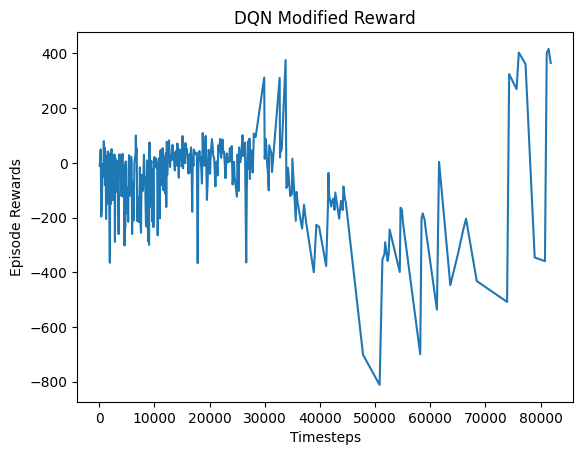

In [35]:
x, y = ts2xy(load_results(log_dir), 'timesteps')
plt.plot(x, y)
# plt.ylim([-300, 300])
plt.title('DQN Modified Reward')
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')
plt.show()

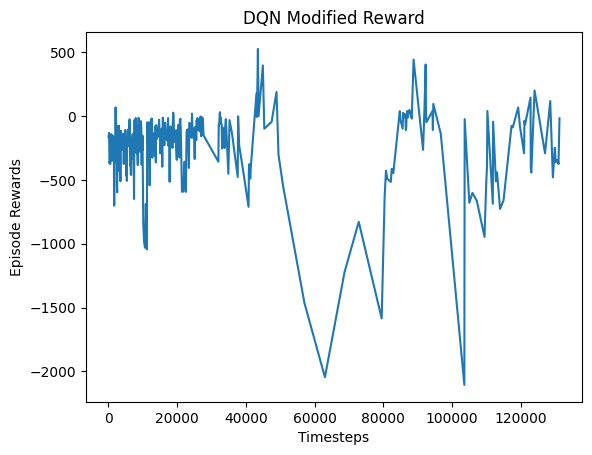

In [75]:
x, y = ts2xy(load_results(log_dir), 'timesteps')
plt.plot(x, y)
# plt.ylim([-300, 300])
plt.title('DQN Modified Reward')
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')
plt.show()

In [ ]:
# import torch
# from stable_baselines3 import DQN
# from stable_baselines3.common.env_util import make_vec_env

# # Assume CustomLunarLander and other necessary imports are defined above

# # Create and configure the environment as it was when the model was saved
# env = CustomLunarLander()
# env.render_mode = "rgb_array"

# # Load the model with the custom environment
# model = DQN.load(model_path, env=env)

# print("Model loaded with the custom environment.")


# Add obstacle

In [9]:

import math
import warnings
from typing import TYPE_CHECKING, Optional

import numpy as np

import gym
from gym import error, spaces
from gym.error import DependencyNotInstalled
from gym.utils import EzPickle, colorize
from gym.utils.step_api_compatibility import step_api_compatibility

try:
    import Box2D
    from Box2D.b2 import (
        circleShape,
        contactListener,
        edgeShape,
        fixtureDef,
        polygonShape,
        revoluteJointDef,
    )
except ImportError:
    raise DependencyNotInstalled("box2d is not installed, run `pip install gym[box2d]`")


if TYPE_CHECKING:
    import pygame


FPS = 50
SCALE = 30.0  # affects how fast-paced the game is, forces should be adjusted as well

MAIN_ENGINE_POWER = 13.0
SIDE_ENGINE_POWER = 0.6

INITIAL_RANDOM = 1000.0  # Set 1500 to make game harder

LANDER_POLY = [(-14, +17), (-17, 0), (-17, -10), (+17, -10), (+17, 0), (+14, +17)]
LEG_AWAY = 20
LEG_DOWN = 18
LEG_W, LEG_H = 2, 8
LEG_SPRING_TORQUE = 40

SIDE_ENGINE_HEIGHT = 14.0
SIDE_ENGINE_AWAY = 12.0

VIEWPORT_W = 600
VIEWPORT_H = 400





class ContactDetector(contactListener):
    def __init__(self, env):
        super().__init__()
        self.env = env

    # def BeginContact(self, contact):
    #     bodyA, bodyB = contact.fixtureA.body, contact.fixtureB.body

    #     # Safely check for 'obstacle' in userData for both bodies involved in the collision
    #     if self.is_obstacle(bodyA) or self.is_obstacle(bodyB):
    #         if self.env.lander in [bodyA, bodyB]:
    #             self.env.obstacle_hit = True
    #             print("Lander has hit the obstacle!")
    #         else:
    #             print("Obstacle was hit, but not by the lander.")

    #     # Check if the lander itself is involved in any collision
    #     if self.env.lander in [bodyA, bodyB]:
    #         self.env.game_over = True
    #         print("Game over: Lander crashed.")

    #     # Check for ground contact for each leg
    #     for i in range(2):
    #         if self.env.legs[i] == bodyA or self.env.legs[i] == bodyB:
    #             if self.env.moon == bodyA or self.env.moon == bodyB:
    #                 self.env.legs[i].ground_contact = True
    #                 print(f"Leg {i + 1} made contact with the ground.")
    def BeginContact(self, contact):
      bodyA, bodyB = contact.fixtureA.body, contact.fixtureB.body

      # Safely check for 'obstacle' in userData for both bodies involved in the collision
      if self.is_obstacle(bodyA) or self.is_obstacle(bodyB):
        if self.env.lander in [bodyA, bodyB]:
            self.env.obstacle_hit = True
            self.env.game_over = True  # Set game over if the lander hits an obstacle.
            # print("Game over: Lander has hit the obstacle!")
        # else:
            # print("Obstacle was hit, but not by the lander.")

      # Check if the lander itself is involved in any collision
      if self.env.lander in [bodyA, bodyB]:
          self.env.game_over = True
          # print("Game over: Lander crashed.")

      # Check for ground or obstacle contact for each leg
      for i in range(2):
        if self.env.legs[i] in [bodyA, bodyB]:
            if self.env.moon in [bodyA, bodyB]:
                self.env.legs[i].ground_contact = True
                # print(f"Leg {i + 1} made contact with the ground.")
            if self.is_obstacle(bodyA) or self.is_obstacle(bodyB):
                self.env.game_over = True  # Set game over if a leg hits an obstacle.
                # print(f"Game over: Leg {i + 1} hit an obstacle.")

    def EndContact(self, contact):
        bodyA, bodyB = contact.fixtureA.body, contact.fixtureB.body

        # Check for ground contact end for each leg
        for i in range(2):
            if self.env.legs[i] == bodyA or self.env.legs[i] == bodyB:
                if self.env.moon == bodyA or self.env.moon == bodyB:
                    self.env.legs[i]. ground_contact = False
                    # print(f"Leg {i + 1} lost contact with the ground.")

    def is_obstacle(self, body):
        """ Helper method to determine if a body is an obstacle. """
        userData = getattr(body, 'userData', {})
        return isinstance(userData, dict) and 'obstacle' in userData


class LunarLanderwithObstacle(gym.Env, EzPickle):
    """
    ### Description
    This environment is a classic rocket trajectory optimization problem.
    According to Pontryagin's maximum principle, it is optimal to fire the
    engine at full throttle or turn it off. This is the reason why this
    environment has discrete actions: engine on or off.

    There are two environment versions: discrete or continuous.
    The landing pad is always at coordinates (0,0). The coordinates are the
    first two numbers in the state vector.
    Landing outside of the landing pad is possible. Fuel is infinite, so an agent
    can learn to fly and then land on its first attempt.

    To see a heuristic landing, run:
    ```
    python gym/envs/box2d/lunar_lander.py
    ```
    <!-- To play yourself, run: -->
    <!-- python examples/agents/keyboard_agent.py LunarLander-v2 -->

    ### Action Space
    There are four discrete actions available: do nothing, fire left
    orientation engine, fire main engine, fire right orientation engine.

    ### Observation Space
    The state is an 8-dimensional vector: the coordinates of the lander in `x` & `y`, its linear
    velocities in `x` & `y`, its angle, its angular velocity, and two booleans
    that represent whether each leg is in contact with the ground or not.

    ### Rewards
    After every step a reward is granted. The total reward of an episode is the
    sum of the rewards for all the steps within that episode.

    For each step, the reward:
    - is increased/decreased the closer/further the lander is to the landing pad.
    - is increased/decreased the slower/faster the lander is moving.
    - is decreased the more the lander is tilted (angle not horizontal).
    - is increased by 10 points for each leg that is in contact with the ground.
    - is decreased by 0.03 points each frame a side engine is firing.
    - is decreased by 0.3 points each frame the main engine is firing.

    The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

    An episode is considered a solution if it scores at least 200 points.

    ### Starting State
    The lander starts at the top center of the viewport with a random initial
    force applied to its center of mass.

    ### Episode Termination
    The episode finishes if:
    1) the lander crashes (the lander body gets in contact with the moon);
    2) the lander gets outside of the viewport (`x` coordinate is greater than 1);
    3) the lander is not awake. From the [Box2D docs](https://box2d.org/documentation/md__d_1__git_hub_box2d_docs_dynamics.html#autotoc_md61),
        a body which is not awake is a body which doesn't move and doesn't
        collide with any other body:
    > When Box2D determines that a body (or group of bodies) has come to rest,
    > the body enters a sleep state which has very little CPU overhead. If a
    > body is awake and collides with a sleeping body, then the sleeping body
    > wakes up. Bodies will also wake up if a joint or contact attached to
    > them is destroyed.

    ### Arguments
    To use to the _continuous_ environment, you need to specify the
    `continuous=True` argument like below:
    ```python
    import gym
    env = gym.make(
        "LunarLander-v2",
        continuous: bool = False,
        gravity: float = -10.0,
        enable_wind: bool = False,
        wind_power: float = 15.0,
        turbulence_power: float = 1.5,
    )
    ```
    If `continuous=True` is passed, continuous actions (corresponding to the throttle of the engines) will be used and the
    action space will be `Box(-1, +1, (2,), dtype=np.float32)`.
    The first coordinate of an action determines the throttle of the main engine, while the second
    coordinate specifies the throttle of the lateral boosters.
    Given an action `np.array([main, lateral])`, the main engine will be turned off completely if
    `main < 0` and the throttle scales affinely from 50% to 100% for `0 <= main <= 1` (in particular, the
    main engine doesn't work  with less than 50% power).
    Similarly, if `-0.5 < lateral < 0.5`, the lateral boosters will not fire at all. If `lateral < -0.5`, the left
    booster will fire, and if `lateral > 0.5`, the right booster will fire. Again, the throttle scales affinely
    from 50% to 100% between -1 and -0.5 (and 0.5 and 1, respectively).

    `gravity` dictates the gravitational constant, this is bounded to be within 0 and -12.

    If `enable_wind=True` is passed, there will be wind effects applied to the lander.
    The wind is generated using the function `tanh(sin(2 k (t+C)) + sin(pi k (t+C)))`.
    `k` is set to 0.01.
    `C` is sampled randomly between -9999 and 9999.

    `wind_power` dictates the maximum magnitude of linear wind applied to the craft. The recommended value for `wind_power` is between 0.0 and 20.0.
    `turbulence_power` dictates the maximum magnitude of rotational wind applied to the craft. The recommended value for `turbulence_power` is between 0.0 and 2.0.

    ### Version History
    - v2: Count energy spent and in v0.24, added turbulance with wind power and turbulence_power parameters
    - v1: Legs contact with ground added in state vector; contact with ground
        give +10 reward points, and -10 if then lose contact; reward
        renormalized to 200; harder initial random push.
    - v0: Initial version

    <!-- ### References -->

    ### Credits
    Created by Oleg Klimov
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": FPS,
    }

    def __init__(
        self,
        render_mode: Optional[str] = None,
        continuous: bool = False,
        gravity: float = -10.0,
        enable_wind: bool = False,
        wind_power: float = 15.0,
        turbulence_power: float = 1.5,
    ):
        EzPickle.__init__(
            self,
            render_mode,
            continuous,
            gravity,
            enable_wind,
            wind_power,
            turbulence_power,
        )

        assert (
            -12.0 < gravity and gravity < 0.0
        ), f"gravity (current value: {gravity}) must be between -12 and 0"
        self.gravity = gravity

        if 0.0 > wind_power or wind_power > 20.0:
            warnings.warn(
                colorize(
                    f"WARN: wind_power value is recommended to be between 0.0 and 20.0, (current value: {wind_power})",
                    "yellow",
                ),
            )
        self.wind_power = wind_power

        if 0.0 > turbulence_power or turbulence_power > 2.0:
            warnings.warn(
                colorize(
                    f"WARN: turbulence_power value is recommended to be between 0.0 and 2.0, (current value: {turbulence_power})",
                    "yellow",
                ),
            )
        self.turbulence_power = turbulence_power
        # self.prev_altitude = None
        # self.hover_penalty = -0.1  # Define how severe the penalty for hovering should be
        # self.hover_threshold = 0.1  # Define how small an altitude change must be to be considered hovering
        # self.hover_counter = 0  # To count how many consecutive steps are considered hovering
        # self.max_hover_allowed = 10  # Max consecutive steps allowed to hover before penalty starts

        self.enable_wind = enable_wind
        self.wind_idx = np.random.randint(-9999, 9999)
        self.torque_idx = np.random.randint(-9999, 9999)

        self.screen: pygame.Surface = None
        self.clock = None
        self.isopen = True
        self.world = Box2D.b2World(gravity=(0, gravity))
        self.moon = None
        self.lander: Optional[Box2D.b2Body] = None
        self.particles = []

        self.prev_reward = None

        self.continuous = continuous

        ##
        self.obstacle_hit = False

        low = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                -1.5,
                -1.5,
                # velocity bounds is 5x rated speed
                -5.0,
                -5.0,
                -math.pi,
                -5.0,
                -0.0,
                -0.0,
            ]
        ).astype(np.float32)
        high = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                1.5,
                1.5,
                # velocity bounds is 5x rated speed
                5.0,
                5.0,
                math.pi,
                5.0,
                1.0,
                1.0,
            ]
        ).astype(np.float32)

        # useful range is -1 .. +1, but spikes can be higher
        self.observation_space = spaces.Box(low, high)

        if self.continuous:
            # Action is two floats [main engine, left-right engines].
            # Main engine: -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power.
            # Left-right:  -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off
            self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)
        else:
            # Nop, fire left engine, main engine, right engine
            self.action_space = spaces.Discrete(4)

        self.render_mode = render_mode

    def _destroy(self):
        if not self.moon:
            return
        self.world.contactListener = None
        self._clean_particles(True)
        self.world.DestroyBody(self.moon)
        self.moon = None
        self.world.DestroyBody(self.lander)
        self.lander = None
        self.world.DestroyBody(self.legs[0])
        self.world.DestroyBody(self.legs[1])

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self._destroy()
        self.world.contactListener_keepref = ContactDetector(self)
        self.world.contactListener = self.world.contactListener_keepref
        self.game_over = False
        self.prev_shaping = None
        self.prev_altitude = None
        self.hover_counter = 0
        W = VIEWPORT_W / SCALE
        H = VIEWPORT_H / SCALE

        # terrain
        CHUNKS = 11
        height = self.np_random.uniform(0, H / 2, size=(CHUNKS + 1,))
        chunk_x = [W / (CHUNKS - 1) * i for i in range(CHUNKS)]
        self.helipad_x1 = chunk_x[CHUNKS // 2 - 1]
        self.helipad_x2 = chunk_x[CHUNKS // 2 + 1]
        self.helipad_y = H / 4
        height[CHUNKS // 2 - 2] = self.helipad_y
        height[CHUNKS // 2 - 1] = self.helipad_y
        height[CHUNKS // 2 + 0] = self.helipad_y
        height[CHUNKS // 2 + 1] = self.helipad_y
        height[CHUNKS // 2 + 2] = self.helipad_y
        smooth_y = [
            0.33 * (height[i - 1] + height[i + 0] + height[i + 1])
            for i in range(CHUNKS)
        ]

        self.moon = self.world.CreateStaticBody(
            shapes=edgeShape(vertices=[(0, 0), (W, 0)])
        )
        self.sky_polys = []
        for i in range(CHUNKS - 1):
            p1 = (chunk_x[i], smooth_y[i])
            p2 = (chunk_x[i + 1], smooth_y[i + 1])
            self.moon.CreateEdgeFixture(vertices=[p1, p2], density=0, friction=0.1)
            self.sky_polys.append([p1, p2, (p2[0], H), (p1[0], H)])

        self.moon.color1 = (0.0, 0.0, 0.0)
        self.moon.color2 = (0.0, 0.0, 0.0)

        initial_y = VIEWPORT_H / SCALE
        self.lander: Box2D.b2Body = self.world.CreateDynamicBody(
            position=(VIEWPORT_W / SCALE / 2, initial_y),
            angle=0.0,
            fixtures=fixtureDef(
                shape=polygonShape(
                    vertices=[(x / SCALE, y / SCALE) for x, y in LANDER_POLY]
                ),
                density=5.0,
                friction=0.1,
                categoryBits=0x0100,
                maskBits=0x001|0x0400,  #maskBits=0x001 | 0x0080,  # collide only with ground
                restitution=0.0,
            ),  # 0.99 bouncy
        )
        self.lander.color1 = (128, 102, 230)
        self.lander.color2 = (77, 77, 128)
        self.lander.ApplyForceToCenter(
            (
                self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
                self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
            ),
            True,
        )

        self.legs = []
        for i in [-1, +1]:
            leg = self.world.CreateDynamicBody(
                position=(VIEWPORT_W / SCALE / 2 - i * LEG_AWAY / SCALE, initial_y),
                angle=(i * 0.05),
                fixtures=fixtureDef(
                    shape=polygonShape(box=(LEG_W / SCALE, LEG_H / SCALE)),
                    density=1.0,
                    restitution=0.0,
                    categoryBits=0x0200,
                    maskBits=0x001|0x0400 ,
                ),
            )
            leg.ground_contact = False
            leg.color1 = (128, 102, 230)
            leg.color2 = (77, 77, 128)
            rjd = revoluteJointDef(
                bodyA=self.lander,
                bodyB=leg,
                localAnchorA=(0, 0),
                localAnchorB=(i * LEG_AWAY / SCALE, LEG_DOWN / SCALE),
                enableMotor=True,
                enableLimit=True,
                maxMotorTorque=LEG_SPRING_TORQUE,
                motorSpeed=+0.3 * i,  # low enough not to jump back into the sky
            )
            if i == -1:
                rjd.lowerAngle = (
                    +0.9 - 0.5
                )  # The most esoteric numbers here, angled legs have freedom to travel within
                rjd.upperAngle = +0.9
            else:
                rjd.lowerAngle = -0.9
                rjd.upperAngle = -0.9 + 0.5
            leg.joint = self.world.CreateJoint(rjd)
            self.legs.append(leg)

        # self.drawlist = [self.lander] + self.legs

        # Define obstacle
        # self.obstacle = self.world.CreateStaticBody(
        # position=(VIEWPORT_W / SCALE / 4, VIEWPORT_H / SCALE / 4),
        # shapes=polygonShape(box=(0.75, 0.75)),  # Dimensions of the obstacle
        # userData={'obstacle': True}
        # )
        # self.obstacle.color1 = (255, 0, 0)
        # self.obstacle.color2 = (180, 0, 0)

        W = VIEWPORT_W / SCALE
        H = VIEWPORT_H / SCALE

        # Create the obstacle positioned in the middle of the screen horizontally
        # and at a strategic vertical position
        middle_x = VIEWPORT_W / SCALE / 2  # Middle of the screen horizontally
        obstacle_y = VIEWPORT_H / SCALE / 2 + 2# A third up the screen vertically

        self.obstacle: Box2D.b2Body = self.world.CreateStaticBody(
        position=(middle_x, obstacle_y),
        shapes=polygonShape(box=(0.75, 0.2)),  # Dimensions of the obstacle
        userData={'obstacle': True}
        )
        self.obstacle.color1 = (255, 0, 0)  # Red color for visibility
        self.obstacle.color2 = (180, 0, 0)
        # self.obstacle.CreateFixture(
        # shape=polygonShape(box=(1, 0.2)),  # Same size as the body's shape
        #         density=0.0,
        #         friction=0.9,
        #         restitution=0.0,
        #         categoryBits=0x0001,
        #         maskBits=0x0010 | 0x0020 ,
        # )

        obstacle_fixture = fixtureDef(
        shape=polygonShape(box=(0.75, 0.2)),
        density=0,  # Static body does not need density
        friction=0.9,
        restitution=0.0,
        categoryBits=0x0400,
        maskBits=0x0100 | 0x0200  # Should interact with lander and legs
        )
        self.obstacle.CreateFixture(obstacle_fixture)


        self.drawlist = [self.lander] + self.legs+[self.obstacle]

        if self.render_mode == "human":
            self.render()
        return self.step(np.array([0, 0]) if self.continuous else 0)[0], {}

    def _create_particle(self, mass, x, y, ttl):
        p = self.world.CreateDynamicBody(
            position=(x, y),
            angle=0.0,
            fixtures=fixtureDef(
                shape=circleShape(radius=2 / SCALE, pos=(0, 0)),
                density=mass,
                friction=0.1,
                categoryBits=0x0300,
                maskBits=0x0010|0x0400,  # collide only with ground
                restitution=0.3,
            ),
        )
        p.ttl = ttl
        self.particles.append(p)
        self._clean_particles(False)
        return p

    def _clean_particles(self, all):
        while self.particles and (all or self.particles[0].ttl < 0):
            self.world.DestroyBody(self.particles.pop(0))

    def step(self, action):
        assert self.lander is not None

        # Update wind
        assert self.lander is not None, "You forgot to call reset()"
        if self.enable_wind and not (
            self.legs[0].ground_contact or self.legs[1].ground_contact
        ):
            # the function used for wind is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            wind_mag = (
                math.tanh(
                    math.sin(0.02 * self.wind_idx)
                    + (math.sin(math.pi * 0.01 * self.wind_idx))
                )
                * self.wind_power
            )
            self.wind_idx += 1
            self.lander.ApplyForceToCenter(
                (wind_mag, 0.0),
                True,
            )

            # the function used for torque is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            torque_mag = math.tanh(
                math.sin(0.02 * self.torque_idx)
                + (math.sin(math.pi * 0.01 * self.torque_idx))
            ) * (self.turbulence_power)
            self.torque_idx += 1
            self.lander.ApplyTorque(
                (torque_mag),
                True,
            )

        if self.continuous:
            action = np.clip(action, -1, +1).astype(np.float32)
        else:
            assert self.action_space.contains(
                action
            ), f"{action!r} ({type(action)}) invalid "

        # Engines
        tip = (math.sin(self.lander.angle), math.cos(self.lander.angle))
        side = (-tip[1], tip[0])
        dispersion = [self.np_random.uniform(-1.0, +1.0) / SCALE for _ in range(2)]

        m_power = 0.0
        if (self.continuous and action[0] > 0.0) or (
            not self.continuous and action == 2
        ):
            # Main engine
            if self.continuous:
                m_power = (np.clip(action[0], 0.0, 1.0) + 1.0) * 0.5  # 0.5..1.0
                assert m_power >= 0.5 and m_power <= 1.0
            else:
                m_power = 1.0
            # 4 is move a bit downwards, +-2 for randomness
            ox = tip[0] * (4 / SCALE + 2 * dispersion[0]) + side[0] * dispersion[1]
            oy = -tip[1] * (4 / SCALE + 2 * dispersion[0]) - side[1] * dispersion[1]
            impulse_pos = (self.lander.position[0] + ox, self.lander.position[1] + oy)
            p = self._create_particle(
                3.5,  # 3.5 is here to make particle speed adequate
                impulse_pos[0],
                impulse_pos[1],
                m_power,
            )  # particles are just a decoration
            p.ApplyLinearImpulse(
                (ox * MAIN_ENGINE_POWER * m_power, oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * MAIN_ENGINE_POWER * m_power, -oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )

        s_power = 0.0
        if (self.continuous and np.abs(action[1]) > 0.5) or (
            not self.continuous and action in [1, 3]
        ):
            # Orientation engines
            if self.continuous:
                direction = np.sign(action[1])
                s_power = np.clip(np.abs(action[1]), 0.5, 1.0)
                assert s_power >= 0.5 and s_power <= 1.0
            else:
                direction = action - 2
                s_power = 1.0
            ox = tip[0] * dispersion[0] + side[0] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            oy = -tip[1] * dispersion[0] - side[1] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            impulse_pos = (
                self.lander.position[0] + ox - tip[0] * 17 / SCALE,
                self.lander.position[1] + oy + tip[1] * SIDE_ENGINE_HEIGHT / SCALE,
            )
            p = self._create_particle(0.7, impulse_pos[0], impulse_pos[1], s_power)
            p.ApplyLinearImpulse(
                (ox * SIDE_ENGINE_POWER * s_power, oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * SIDE_ENGINE_POWER * s_power, -oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )

        self.world.Step(1.0 / FPS, 6 * 30, 2 * 30)

        pos = self.lander.position
        vel = self.lander.linearVelocity
        state = [
            (pos.x - VIEWPORT_W / SCALE / 2) / (VIEWPORT_W / SCALE / 2),
            (pos.y - (self.helipad_y + LEG_DOWN / SCALE)) / (VIEWPORT_H / SCALE / 2),
            vel.x * (VIEWPORT_W / SCALE / 2) / FPS,
            vel.y * (VIEWPORT_H / SCALE / 2) / FPS,
            self.lander.angle,
            20.0 * self.lander.angularVelocity / FPS,
            1.0 if self.legs[0].ground_contact else 0.0,
            1.0 if self.legs[1].ground_contact else 0.0,
        ]
        assert len(state) == 8

        reward = 0
        shaping = (
            -100 * np.sqrt(state[0] * state[0] + state[1] * state[1])
            - 100 * np.sqrt(state[2] * state[2] + state[3] * state[3])
            - 100 * abs(state[4])
            + 10 * state[6]
            + 10 * state[7]
        )  # And ten points for legs contact, the idea is if you
        # lose contact again after landing, you get negative reward
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        reward -= (
            m_power * 0.30
        )  # less fuel spent is better, about -30 for heuristic landing
        reward -= s_power * 0.03

        terminated = False
        if self.game_over or abs(state[0]) >= 1.0:
            terminated = True
            reward = -100
        if not self.lander.awake:
            terminated = True
            reward = +200
            # Check for collision with the obstacle
        pos = self.lander.position
        vel = self.lander.linearVelocity
        # current_altitude = pos.y

        # # Check if previous altitude is initialized
        # if self.prev_altitude is not None:
        #     # Check if the lander is hovering
        #     if abs(self.prev_altitude - current_altitude) < self.hover_threshold:
        #         self.hover_counter += 1
        #     else:
        #         self.hover_counter = 0

        # # Apply hover penalty if hovering too long
        # if self.hover_counter > self.max_hover_allowed:
        #     reward += self.hover_penalty

        # self.prev_altitude = current_altitude  # Update the previous altitude
##################################################
        # # At the end of the step method, before returning the step result
        # center_distance = np.sqrt(state[0]**2 + state[1]**2)
        # reward -= 200 * center_distance  # Stronger penalty for being away from center
        # if center_distance < 0.1:  # Very close to center
        #     reward += 100  # Large bonus for precision landing
        # contact_bonus = 10 * (state[6] + state[7])
        # center_multiplier = max(0, 1 - 10 * center_distance)
        # reward += contact_bonus * center_multiplier  # Adjusted contact bonus
##################################################

        if self.obstacle_hit:
          reward -= 100  # Apply penalty for hitting the obstacle
          self.game_over = True  # Optionally end the game
          self.obstacle_hit = False  # Reset the flag
        # if reward<-200:
        #   reward+=-100
          terminated=True
          self.game_over = True
        # print("reward=", reward)
        if self.render_mode == "human":
            self.render()
        return np.array(state, dtype=np.float32), reward, terminated, False, {}

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[box2d]`"
            )

        if self.screen is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.screen = pygame.display.set_mode((VIEWPORT_W, VIEWPORT_H))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        self.surf = pygame.Surface((VIEWPORT_W, VIEWPORT_H))

        pygame.transform.scale(self.surf, (SCALE, SCALE))
        pygame.draw.rect(self.surf, (255, 255, 255), self.surf.get_rect())



      # Draw the terrain and other elements
      # Existing drawing code for terrain, lander, particles, etc.


        # self.surf = pygame.transform.flip(self.surf, False, True)

        for obj in self.particles:
            obj.ttl -= 0.15
            obj.color1 = (
                int(max(0.2, 0.15 + obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
            )
            obj.color2 = (
                int(max(0.2, 0.15 + obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
            )

        self._clean_particles(False)

        for p in self.sky_polys:
            scaled_poly = []
            for coord in p:
                scaled_poly.append((coord[0] * SCALE, coord[1] * SCALE))
            pygame.draw.polygon(self.surf, (0, 0, 0), scaled_poly)
            gfxdraw.aapolygon(self.surf, scaled_poly, (0, 0, 0))

        for obj in self.particles + self.drawlist:
            for f in obj.fixtures:
                trans = f.body.transform
                if type(f.shape) is circleShape:
                    pygame.draw.circle(
                        self.surf,
                        color=obj.color1,
                        center=trans * f.shape.pos * SCALE,
                        radius=f.shape.radius * SCALE,
                    )
                    pygame.draw.circle(
                        self.surf,
                        color=obj.color2,
                        center=trans * f.shape.pos * SCALE,
                        radius=f.shape.radius * SCALE,
                    )

                else:
                    path = [trans * v * SCALE for v in f.shape.vertices]
                    pygame.draw.polygon(self.surf, color=obj.color1, points=path)
                    gfxdraw.aapolygon(self.surf, path, obj.color1)
                    pygame.draw.aalines(
                        self.surf, color=obj.color2, points=path, closed=True
                    )

                for x in [self.helipad_x1, self.helipad_x2]:
                    x = x * SCALE
                    flagy1 = self.helipad_y * SCALE
                    flagy2 = flagy1 + 50
                    pygame.draw.line(
                        self.surf,
                        color=(255, 255, 255),
                        start_pos=(x, flagy1),
                        end_pos=(x, flagy2),
                        width=1,
                    )
                    pygame.draw.polygon(
                        self.surf,
                        color=(204, 204, 0),
                        points=[
                            (x, flagy2),
                            (x, flagy2 - 10),
                            (x + 25, flagy2 - 5),
                        ],
                    )
                    gfxdraw.aapolygon(
                        self.surf,
                        [(x, flagy2), (x, flagy2 - 10), (x + 25, flagy2 - 5)],
                        (204, 204, 0),
                    )
              # Draw the obstacle
        # if self.obstacle:
        #   # Assuming obstacle's position and size have been defined appropriately
        #   obs_pos = self.obstacle.position
        #   obs_poly = [(obs_pos.x + x, obs_pos.y + y) for x, y in [(-0.5, 0.2), (0.5, 0.2), (0.5, -0.2), (-0.5, -0.2)]]
        #   obs_poly_scaled = [(x * SCALE, VIEWPORT_H - y * SCALE) for x, y in obs_poly]  # Adjust for Pygame coordinates system
        #   pygame.draw.polygon(self.surf, (255, 0, 0), obs_poly_scaled)  # Draw the obstacle in red

        self.surf = pygame.transform.flip(self.surf, False, True)

        if self.render_mode == "human":
            assert self.screen is not None
            self.screen.blit(self.surf, (0, 0))
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()
        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.surf)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False


def heuristic(env, s):
    """
    The heuristic for
    1. Testing
    2. Demonstration rollout.

    Args:
        env: The environment
        s (list): The state. Attributes:
            s[0] is the horizontal coordinate
            s[1] is the vertical coordinate
            s[2] is the horizontal speed
            s[3] is the vertical speed
            s[4] is the angle
            s[5] is the angular speed
            s[6] 1 if first leg has contact, else 0
            s[7] 1 if second leg has contact, else 0

    Returns:
         a: The heuristic to be fed into the step function defined above to determine the next step and reward.
    """

    angle_targ = s[0] * 0.5 + s[2] * 1.0  # angle should point towards center
    if angle_targ > 0.4:
        angle_targ = 0.4  # more than 0.4 radians (22 degrees) is bad
    if angle_targ < -0.4:
        angle_targ = -0.4
    hover_targ = 0.55 * np.abs(
        s[0]
    )  # target y should be proportional to horizontal offset

    angle_todo = (angle_targ - s[4]) * 0.5 - (s[5]) * 1.0
    hover_todo = (hover_targ - s[1]) * 0.5 - (s[3]) * 0.5

    if s[6] or s[7]:  # legs have contact
        angle_todo = 0
        hover_todo = (
            -(s[3]) * 0.5
        )  # override to reduce fall speed, that's all we need after contact

    if env.continuous:
        a = np.array([hover_todo * 20 - 1, -angle_todo * 20])
        a = np.clip(a, -1, +1)
    else:
        a = 0
        if hover_todo > np.abs(angle_todo) and hover_todo > 0.05:
            a = 2
        elif angle_todo < -0.05:
            a = 3
        elif angle_todo > +0.05:
            a = 1
    return a


def demo_heuristic_lander(env, seed=None, render=False):

    total_reward = 0
    steps = 0
    s, info = env.reset(seed=seed)
    while True:
        a = heuristic(env, s)
        s, r, terminated, truncated, info = step_api_compatibility(env.step(a), True)
        total_reward += r

        if render:
            still_open = env.render()
            if still_open is False:
                break

        if steps % 20 == 0 or terminated or truncated:
            print("observations:", " ".join([f"{x:+0.2f}" for x in s]))
            print(f"step {steps} total_reward {total_reward:+0.2f}")
        steps += 1
        if terminated or truncated:
            break
    if render:
        env.close()
    return total_reward


class LunarLanderContinuous:
    def __init__(self):
        raise error.Error(
            "Error initializing LunarLanderContinuous Environment.\n"
            "Currently, we do not support initializing this mode of environment by calling the class directly.\n"
            "To use this environment, instead create it by specifying the continuous keyword in gym.make, i.e.\n"
            'gym.make("LunarLander-v2", continuous=True)'
        )




from gym.envs.registration import registry, register, make, spec

register(
    id='LunarLanderDefault-v2',
    entry_point='__main__:LunarLanderwithObstacle',
    max_episode_steps=1000,
    reward_threshold=300,
)



## Check before learning

In [12]:

env_name="CustomLunarLander-v2"


env=LunarLanderwithObstacle()
env.render_mode="rgb_array"
vid = VideoRecorder(env, path=f"video/{env_name}_pretraining.mp4")
observation = env.reset()[0]

total_reward = 0
done = False
while not done:
  frame = env.render()
  vid.capture_frame()
  action =0# np.random.randint(4)
  observation, reward, done, info, _ = env.step(action)
  total_reward += reward
vid.close()
env.close()
print(f"\nTotal reward: {total_reward}")

# show video
html = render_mp4(f"video/{env_name}_pretraining.mp4")
HTML(html)

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(



Total reward: -145.59054710073815


## Learning

In [16]:
nn_layers = [64,64,64]  # This is the configuration of your neural network.
learning_rate = 0.0001  # This is the step-size with which the gradient descent is carried out.

exploration_initial_eps = 1  # initial value of random action probability. Range is between 0 and 1.
exploration_fraction = 0.5  # fraction of entire training period over which the exploration rate is reduced. Range is between 0 and 1.



In [17]:

log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env_name="CustomLunarLander-v3"

env=LunarLanderwithObstacle()
env.render_mode="rgb_array"

env = stable_baselines3.common.monitor.Monitor(env, log_dir )

callback = EvalCallback(env, log_path=log_dir, deterministic=True)  # For evaluating the performance of the agent periodically and logging the results.
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=nn_layers)


model = DQN("MlpPolicy", env,policy_kwargs = policy_kwargs,
            learning_rate=learning_rate,
            batch_size=128,
            buffer_size=128,  # size of experience of replay buffer.
            learning_starts=1,  # learning starts immediately!
            gamma=0.99,  # discount facto. range is between 0 and 1.
            tau = 1,  # the soft update coefficient for updating the target network
            target_update_interval=30,  # update the target network immediately.
            train_freq=(1,"step"),  # train the network at every step.
            max_grad_norm = 10,  # the maximum value for the gradient clipping
            exploration_initial_eps = exploration_initial_eps,  # initial value of random action probability
            exploration_fraction =exploration_fraction,  # fraction of entire training period over which the exploration rate is reduced
            gradient_steps = 1,  # number of gradient steps
            seed = 1,  # seed for the pseudo random generators
            verbose=0)  # Set verbose to 1 to observe training logs. We encourage you to set the verbose to 1.



In [18]:
model.learn(total_timesteps=60000, log_interval=10, callback=callback)

# Save the model
model_path = os.path.join(log_dir, "obstacle_model.zip")
model.save(model_path)

print(f"Model saved to {model_path}")

from google.colab import files

# Download the file to your local machine
files.download(model_path)

Eval num_timesteps=10000, episode_reward=-94.63 +/- 57.16
Episode length: 385.40 +/- 165.74
New best mean reward!
Eval num_timesteps=20000, episode_reward=-92.44 +/- 58.45
Episode length: 75.80 +/- 51.83
New best mean reward!
Eval num_timesteps=30000, episode_reward=-151.37 +/- 29.69
Episode length: 428.20 +/- 151.72
Eval num_timesteps=40000, episode_reward=-536.79 +/- 278.31
Episode length: 2744.00 +/- 1556.01
Eval num_timesteps=50000, episode_reward=-141.85 +/- 61.26
Episode length: 432.60 +/- 184.34
Eval num_timesteps=60000, episode_reward=51.34 +/- 160.95
Episode length: 570.60 +/- 251.87
New best mean reward!
Model saved to /tmp/gym/obstacle_model.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# Load the model
model_path = os.path.join(log_dir, "obstacle_model.zip")

model = DQN.load(model_path, env=env)

print("Model loaded successfully!")

Model loaded successfully!


## Check after learning

In [23]:
# Create environment
env_name="CustomLunarLander-v3"
env=LunarLanderwithObstacle()
env.render_mode="rgb_array"

vid = VideoRecorder(env, path=f"video/{env_name}_obstacle_learend.mp4")
observation = env.reset()[0]

total_reward = 0
done = False
while not done:
  frame = env.render()
  vid.capture_frame()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info, _ = env.step(action)
  total_reward += reward
vid.close()
env.close()
print(f"\nTotal reward: {total_reward}")

# show video
html = render_mp4(f"video/{env_name}_obstacle_learend.mp4")
HTML(html)

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(



Total reward: 210.49764375535324


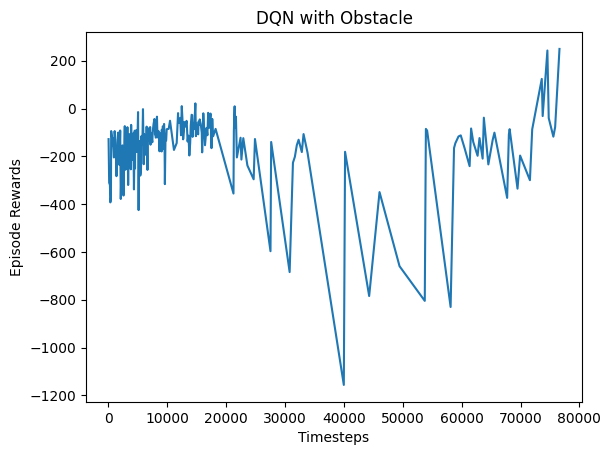

In [21]:
x, y = ts2xy(load_results(log_dir), 'timesteps')
plt.plot(x, y)
# plt.ylim([-300, 300])
plt.title('DQN with Obstacle')
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')
plt.show()